# Tree-informed optimal transport of single-cell and spatial transcriptomics
Here we generate fake data consisting of paired spatial and single-cell gene expression data. We use Cassiopeia to generate a phylogenetic tree of single-cells and place them in 2D space, and from that we generate single-cell and spot-based gene expression. We then apply various approaches to map the single-cell data to spots.

In [140]:
import anndata
import cassiopeia as cas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import squidpy as sq
import scanpy as sc
import seaborn as sns

import importlib
import os

file_path = os.path.join(os.getcwd(), "../src/spotr/", "space_simulator.py")
spec = importlib.util.spec_from_file_location("space_simulator", file_path)
space_simulator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(space_simulator)

file_path = os.path.join(os.getcwd(), "../src/spotr/", "expression_simulator.py")
spec = importlib.util.spec_from_file_location("expression_simulator", file_path)
expression_simulator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(expression_simulator)

file_path = os.path.join(os.getcwd(), "../src/spotr/", "visium_simulator.py")
spec = importlib.util.spec_from_file_location("visium_simulator", file_path)
visium_simulator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(visium_simulator)

file_path = os.path.join(os.getcwd(), "../src/spotr/", "mappers.py")
spec = importlib.util.spec_from_file_location("mappers", file_path)
mappers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mappers)

file_path = os.path.join(os.getcwd(), "../src/spotr/", "utils.py")
spec = importlib.util.spec_from_file_location("utils", file_path)
utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(utils)

file_path = os.path.join(os.getcwd(), "../src/spotr/", "spotr.py")
spec = importlib.util.spec_from_file_location("spotr", file_path)
spotr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(spotr)

## Generate cell lineage tree and spatial locations

In [120]:
ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix, spatial_distance_matrix, true_couplings, simulated_tree = utils.simulate_data('1', seed=1)

In [121]:
spatial_simulated_adata.obsm['clade_level2_fractions']

clade4    clade5    clade6    clade7
spot_89   0.500000  0.500000  0.000000  0.000000
spot_26   0.666667  0.333333  0.000000  0.000000
spot_27   0.666667  0.333333  0.000000  0.000000
spot_28   0.500000  0.500000  0.000000  0.000000
spot_29   0.500000  0.500000  0.000000  0.000000
...            ...       ...       ...       ...
spot_120  0.000000  0.333333  0.000000  0.666667
spot_82   0.000000  0.000000  0.250000  0.750000
spot_81   0.000000  0.000000  0.333333  0.666667
spot_78   0.000000  0.000000  0.000000  1.000000
spot_83   0.000000  0.333333  0.000000  0.666667

[180 rows x 4 columns]

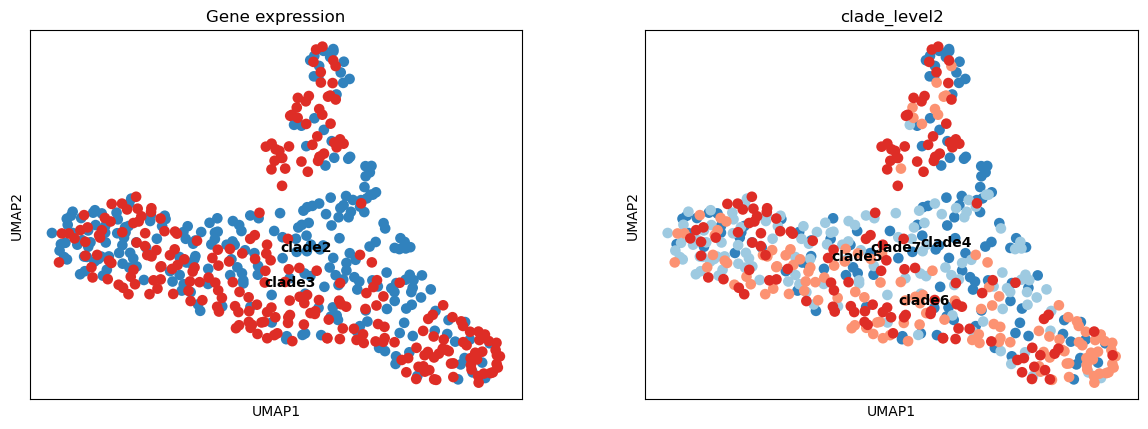

/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


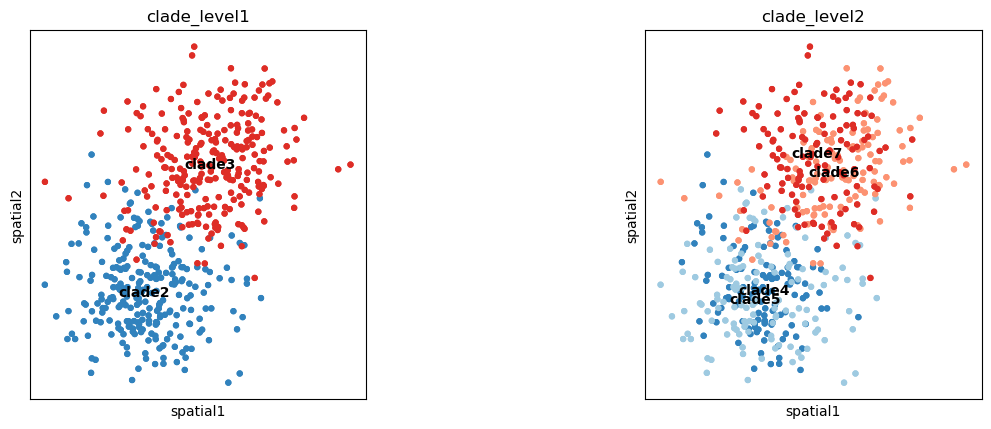

In [93]:
ss_simulated_adata.uns['clade_level1_colors'] = ['#3182bd', '#de2d26',]
ss_simulated_adata.uns['clade_level2_colors'] = ['#3182bd', '#9ecae1', '#fc9272', '#de2d26']
sc.pp.neighbors(ss_simulated_adata)
sc.tl.umap(ss_simulated_adata)
sc.pl.umap(ss_simulated_adata, color=['clade_level1', 'clade_level2'] , title='Gene expression', legend_loc='on data')
sq.pl.spatial_scatter(ss_simulated_adata, color=['clade_level1', 'clade_level2'], library_id='puck1',
                    size=50, shape=None, legend_loc='on data', ncols=3)

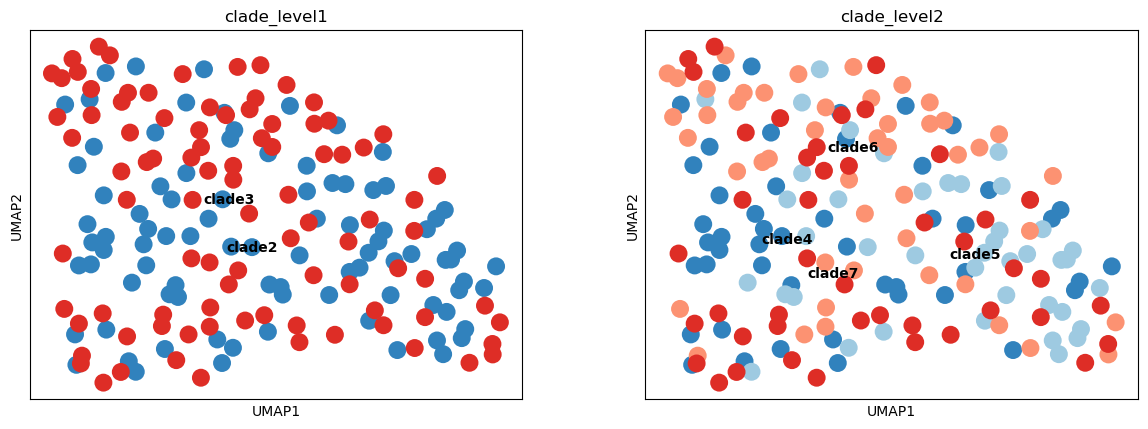

/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


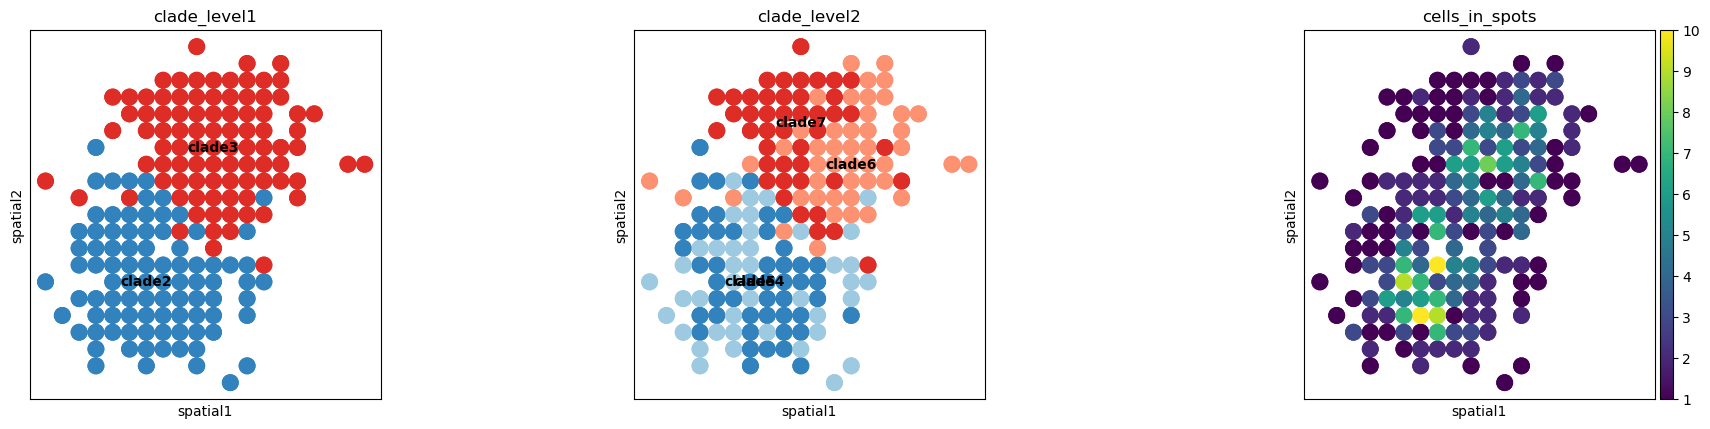

In [101]:
spatial_simulated_adata.uns['clade_level1_colors'] = ['#3182bd', '#de2d26',]
spatial_simulated_adata.uns['clade_level2_colors'] = ['#3182bd', '#9ecae1', '#fc9272', '#de2d26']
sc.pp.neighbors(spatial_simulated_adata)
sc.tl.umap(spatial_simulated_adata)
sc.pl.umap(spatial_simulated_adata, color=['clade_level1', 'clade_level2'], legend_loc='on data')
sq.pl.spatial_scatter(spatial_simulated_adata, color=['clade_level1', 'clade_level2', 'cells_in_spots'], 
                    library_id='puck1', shape=None, legend_loc='on data', size=500)

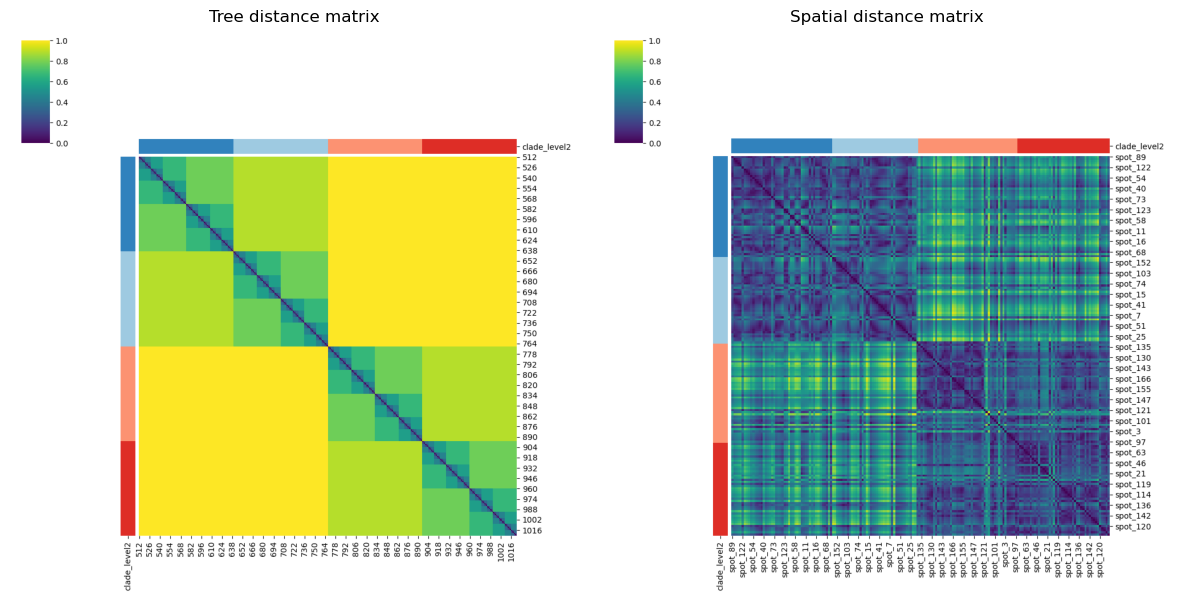

In [95]:
lut = dict(zip(["clade4", "clade5", "clade6", "clade7"], ss_simulated_adata.uns['clade_level2_colors']))
row_colors = ss_simulated_adata.obs['clade_level2'].map(lut)
g1 = sns.clustermap(tree_distance_matrix, row_cluster=False, col_cluster=False, row_colors=row_colors, col_colors=row_colors, cmap='viridis')

row_colors = spatial_simulated_adata.obs['clade_level2'].map(lut)
g2 = sns.clustermap(spatial_distance_matrix, row_cluster=False, col_cluster=False, row_colors=row_colors, col_colors=row_colors, cmap='viridis')

g1.figure.canvas.draw()
g2.figure.canvas.draw()

img1 = np.array(g1.figure.canvas.renderer.buffer_rgba())
img2 = np.array(g2.figure.canvas.renderer.buffer_rgba())

plt.close(g1.figure)
plt.close(g2.figure)

# Combine into one figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].set_title('Tree distance matrix')
axes[0].axis('off')

axes[1].imshow(img2)
axes[1].set_title('Spatial distance matrix')
axes[1].axis('off')

plt.tight_layout()
plt.show()


/Users/pedroferreira/projects/tumorot/phylospatial_mapping/notebooks/../src/spotr/utils.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'clade4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[subtree, 'clade'] = f'clade{node}'
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


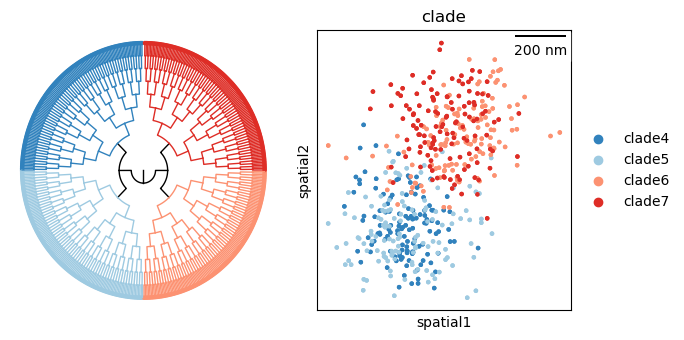

In [97]:
utils.plot_selection(simulated_tree, ss_simulated_adata, ['4', '5', '6', '7'], ['#3182bd', '#9ecae1', '#fc9272', '#de2d26'], orient=90)

In [134]:
spatial_simulated_adata.obsm['clade_level2_fractions'], spatial_simulated_adata.obsm['inferred_clade_level2_fractions']

(            clade4    clade5    clade6    clade7
 spot_89   0.500000  0.500000  0.000000  0.000000
 spot_26   0.666667  0.333333  0.000000  0.000000
 spot_27   0.666667  0.333333  0.000000  0.000000
 spot_28   0.500000  0.500000  0.000000  0.000000
 spot_29   0.500000  0.500000  0.000000  0.000000
 ...            ...       ...       ...       ...
 spot_120  0.000000  0.333333  0.000000  0.666667
 spot_82   0.000000  0.000000  0.250000  0.750000
 spot_81   0.000000  0.000000  0.333333  0.666667
 spot_78   0.000000  0.000000  0.000000  1.000000
 spot_83   0.000000  0.333333  0.000000  0.666667
 
 [180 rows x 4 columns],
             clade4    clade5    clade6    clade7
 spot_89   0.206479  0.283807  0.297792  0.211922
 spot_26   0.218706  0.281855  0.219626  0.279813
 spot_27   0.203281  0.281365  0.340030  0.175324
 spot_28   0.212304  0.334975  0.223295  0.229426
 spot_29   0.207514  0.329246  0.225471  0.237769
 ...            ...       ...       ...       ...
 spot_120  0.202122  0.

In [ ]:
# TODO: SpOTr is the algorithm that runs from level 0 to level 2 learning an alpha at each step.

modes = ['1']#, '2', '3', '4']
n_reps = 1
K = 5

results_rows = []
for mode in modes:
    for rep in range(n_reps):
        ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix, spatial_distance_matrix, true_couplings, simulated_tree = utils.simulate_data(mode, seed=rep)
        C_feature, C_tree, C_space, a, b = spotr.prepare_ot_inputs(ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix.values, spatial_distance_matrix.values)
        true_structure_score_level0 = utils.structural_concordance(C_tree, C_space, true_couplings, eps=1e-12)
        true_structure_score_level1 = utils.structural_concordance(C_tree, C_space, true_couplings, eps=1e-12)
        true_structure_score_level2 = utils.structural_concordance(C_tree, C_space, true_couplings, eps=1e-12)

        results_rows.append({
            'mode': mode,
            'rep': rep,
            'method': 'true',
            'pcorr': 1.,
            'structure_level0': true_structure_score_level0,
            'structure_level1': true_structure_score_level1,
            'structure_level2': true_structure_score_level2
        })

        # Run Correlation-based mapping
        coupling = mappers.pairwise_correlations(np.asarray(ss_simulated_adata.X), np.asarray(spatial_simulated_adata.X))
        utils.compute_inferred_clade_fractions(ss_simulated_adata, coupling, spatial_simulated_adata, clade_column='clade_level2')
        mean_pearson_corr = utils.compute_clades_pearson_corr(spatial_simulated_adata.obsm['clade_level2_fractions'], spatial_simulated_adata.obsm['inferred_clade_level2_fractions'])
        structure_score_level0 = utils.structural_concordance(C_tree, C_space, coupling, eps=1e-12)
        structure_score_level1 = utils.structural_concordance(C_tree, C_space, coupling, eps=1e-12)
        structure_score_level2 = utils.structural_concordance(C_tree, C_space, coupling, eps=1e-12)

        results_rows.append({
            'mode': mode,
            'rep': rep,
            'method': 'correlation',
            'pcorr': mean_pearson_corr,
            'structure_level0': structure_score_level0,
            'structure_level1': structure_score_level1,
            'structure_level2': structure_score_level2
        })

        # Run Wasserstein OT
        coupling, _ = spotr.sinkhorn_fgw(C_feature, C_tree, C_space, a, b, 0.01, T_sinkhorn=100, J_alt=20, 
                                    alpha=0.0, gamma0=None, uv0=None)
        utils.compute_inferred_clade_fractions(ss_simulated_adata, coupling, spatial_simulated_adata, clade_column='clade_level2')
        mean_pearson_corr = utils.compute_clades_pearson_corr(spatial_simulated_adata.obsm['clade_level2_fractions'], spatial_simulated_adata.obsm['inferred_clade_level2_fractions'])
        structure_score = utils.structural_concordance(C_tree, C_space, coupling, eps=1e-12)

        results_rows.append({
            'mode': mode,
            'rep': rep,
            'method': 'Wasserstein OT',
            'pcorr': mean_pearson_corr,
            'structure_level0': structure_score_level0,
            'structure_level1': structure_score_level1,
            'structure_level2': structure_score_level2
        })

        # Run GW OT
        coupling, _ = spotr.sinkhorn_fgw(C_feature, C_tree, C_space, a, b, .01, T_sinkhorn=100, J_alt=20, alpha=1.0, gamma0=None, uv0=None)
        utils.compute_inferred_clade_fractions(ss_simulated_adata, coupling, spatial_simulated_adata, clade_column='clade_level2')
        mean_pearson_corr = utils.compute_clades_pearson_corr(spatial_simulated_adata.obsm['clade_level2_fractions'], spatial_simulated_adata.obsm['inferred_clade_level2_fractions'])
        structure_score = utils.structural_concordance(C_tree, C_space, coupling, eps=1e-12)

        results_rows.append({
            'mode': mode,
            'rep': rep,
            'method': 'GW OT',
            'pcorr': mean_pearson_corr,
            'structure_level0': structure_score_level0,
            'structure_level1': structure_score_level1,
            'structure_level2': structure_score_level2
        })


        # Run SpOTr-global
        cell_type_assignments = ss_simulated_adata.obsm['trait_activations'].values / np.sum(ss_simulated_adata.obsm['trait_activations'].values, axis=1, keepdims=True)
        cell_type_signatures = ss_simulated_adata.uns['trait_signatures'].values
        alphas, alphas_hist, loss_hist, coupling = spotr.run_spotr(ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix, spatial_distance_matrix,
                                                                     cell_type_assignments, cell_type_signatures,
                                                                     clade_column='clade_level0', sigma=0.01)     
        utils.compute_inferred_clade_fractions(ss_simulated_adata, coupling, spatial_simulated_adata, clade_column='clade_level2')
        mean_pearson_corr = utils.compute_clades_pearson_corr(spatial_simulated_adata.obsm['clade_level2_fractions'], spatial_simulated_adata.obsm['inferred_clade_level2_fractions'])
        structure_score = utils.structural_concordance(C_tree, C_space, coupling, eps=1e-12)
        results_rows.append({
            'mode': mode,
            'rep': rep,
            'method': 'SpOTr-global',
            'pcorr': mean_pearson_corr,
            'structure_level0': structure_score_level0,
            'structure_level1': structure_score_level1,
            'structure_level2': structure_score_level2
        })

        # Run SpOTr-clade1
        alphas, alphas_hist, loss_hist, coupling = spotr.run_spotr(ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix, spatial_distance_matrix,
                                                                     cell_type_assignments, cell_type_signatures,
                                                                     clade_column='clade_level1', sigma=0.01)
        utils.compute_inferred_clade_fractions(ss_simulated_adata, coupling, spatial_simulated_adata, clade_column='clade_level2')
        mean_pearson_corr = utils.compute_clades_pearson_corr(spatial_simulated_adata.obsm['clade_level2_fractions'], spatial_simulated_adata.obsm['inferred_clade_level2_fractions'])
        structure_score = utils.structural_concordance(C_tree, C_space, coupling, eps=1e-12)

        results_rows.append({
            'mode': mode,
            'rep': rep,
            'method': 'SpOTr-clade1',
            'pcorr': mean_pearson_corr,
            'structure_level0': structure_score_level0,
            'structure_level1': structure_score_level1,
            'structure_level2': structure_score_level2
        })

        # Run SpOTr-clade2
        alphas, alphas_hist, loss_hist, coupling = spotr.run_spotr(ss_simulated_adata, spatial_simulated_adata, tree_distance_matrix, spatial_distance_matrix,
                                                                     cell_type_assignments, cell_type_signatures,
                                                                     clade_column='clade_level2', sigma=0.01)
        utils.compute_inferred_clade_fractions(ss_simulated_adata, coupling, spatial_simulated_adata, clade_column='clade_level2')
        mean_pearson_corr = utils.compute_clades_pearson_corr(spatial_simulated_adata.obsm['clade_level2_fractions'], spatial_simulated_adata.obsm['inferred_clade_level2_fractions'])
        structure_score = utils.structural_concordance(C_tree, C_space, coupling, eps=1e-12)

        results_rows.append({
            'mode': mode,
            'rep': rep,
            'method': 'SpOTr-clade2',
            'pcorr': mean_pearson_corr,
            'structure_level0': structure_score_level0,
            'structure_level1': structure_score_level1,
            'structure_level2': structure_score_level2
        })

        print(results_rows[-6:])

    results_df = pd.DataFrame(results_rows)

/Users/pedroferreira/projects/tumorot/phylospatial_mapping/notebooks/../src/spotr/utils.py:323: ImplicitModificationWarning: Setting element `.obsm['inferred_clade_level2_fractions']` of view, initializing view as actual.
  spatial_simulated_adata.obsm[key] = inferred_clade_fractions_df
100%|██████████| 100/100 [00:10<00:00,  9.94it/s, loss=9.52e+4]


[{'mode': '1', 'rep': 0, 'method': 'correlation', 'pcorr': np.float64(0.037337487515112094), 'structure': np.float32(0.50433826)}, {'mode': '1', 'rep': 0, 'method': 'Wasserstein OT', 'pcorr': np.float64(0.42721966119712595), 'structure': np.float32(0.5445715)}, {'mode': '1', 'rep': 0, 'method': 'Wasserstein OT', 'pcorr': np.float64(0.6540032576783752), 'structure': np.float32(0.8231398)}, {'mode': '1', 'rep': 0, 'method': 'SpOTr-global', 'pcorr': np.float64(0.3861581670966784), 'structure': np.float32(0.5285105)}, {'mode': '1', 'rep': 0, 'method': 'SpOTr-clade1', 'pcorr': np.float64(0.3770291010905996), 'structure': np.float32(0.52771384)}, {'mode': '1', 'rep': 0, 'method': 'SpOTr-clade2', 'pcorr': np.float64(0.37673790009407704), 'structure': np.float32(0.52692914)}]


In [149]:
results_df

mode  rep          method     pcorr  structure
0    1    0            true  1.000000   0.863951
1    1    0     correlation  0.037337   0.504338
2    1    0  Wasserstein OT  0.427220   0.544572
3    1    0  Wasserstein OT  0.654003   0.823140
4    1    0    SpOTr-global  0.386158   0.528511
5    1    0    SpOTr-clade1  0.377029   0.527714
6    1    0    SpOTr-clade2  0.376738   0.526929

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

modes = results_df['mode'].unique()
n_modes = len(modes)

fig, axes = plt.subplots(1, n_modes, figsize=(6 * n_modes, 6), sharey=True)

if n_modes == 1:
    axes = [axes]

for ax, mode in zip(axes, modes):
    sns.boxplot(
        data=results_df[results_df['mode'] == mode],
        x="method",
        y="pcorr",
        ax=ax
    )
    ax.set_title(f"Mode: {mode}")
    ax.set_ylabel("Mean clade2 Pearson correlation")
    ax.set_xlabel("Method")
    ax.set_ylim(0, 1)  # adjust if you want fixed scale

plt.tight_layout()
plt.show()



### Complete binary tree

In [652]:
tree_simulator = cas.sim.CompleteBinarySimulator(num_cells=512)
spatial_simulator = space_simulator.BrownianSpatialDataSimulator(2, 1.)

In [653]:
np.random.seed(1234678)
simulated_tree = tree_simulator.simulate_tree()

In [654]:
import ete3
phylotree = ete3.Tree(simulated_tree.get_newick())
spatial_simulator.make_leaf_cov_matrix(phylotree)

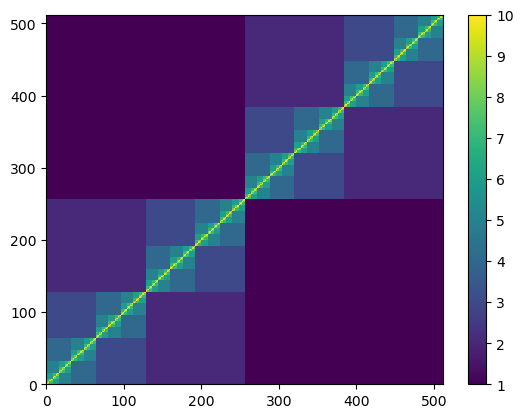

In [655]:
plt.pcolormesh(spatial_simulator.leaf_cov_matrix)
plt.colorbar()
plt.show()

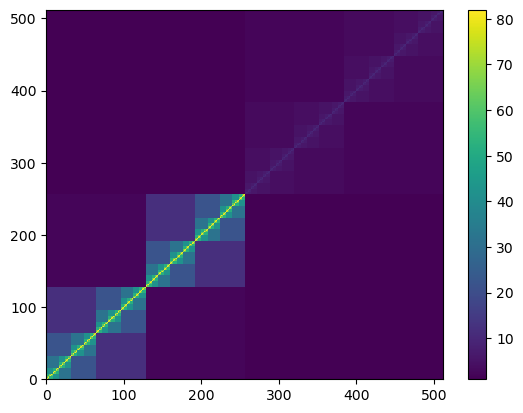

In [656]:
clade = simulated_tree.leaves_in_subtree(simulated_tree.children('1')[0])
rate = 10.
S, _ = spatial_simulator.rescale_clade(clade, rate)
plt.pcolormesh(S)
plt.colorbar()
plt.show()

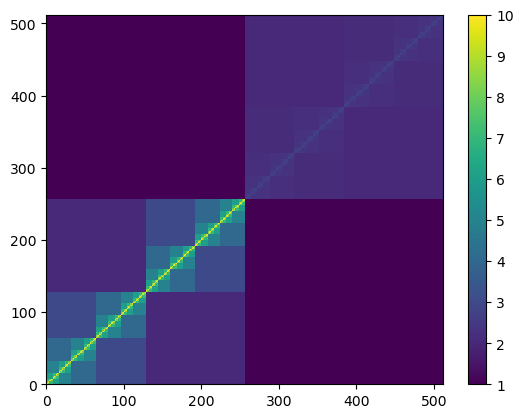

In [657]:
clade = simulated_tree.leaves_in_subtree(simulated_tree.children('1')[1])
rate = .1
S, _ = spatial_simulator.rescale_clade(clade, rate)
plt.pcolormesh(S)
plt.colorbar()
plt.show()

In [658]:
clades = [simulated_tree.leaves_in_subtree(simulated_tree.children('1')[0]),
        simulated_tree.leaves_in_subtree(simulated_tree.children('1')[1])]
rates = [.1, .1]
spatial_simulator.overlay_data(simulated_tree, clades=clades, rates=rates, brownian_motion=True, lambda_brownian=1.)

In [659]:
top_clades = ['2', '3']
clades = []
subclades = []
subsubclades = []
for i, clade in enumerate(top_clades):
    leaves = simulated_tree.leaves_in_subtree(clade)
    clades.append(leaves)
    for j, subclade in enumerate(simulated_tree.children(clade)):
        subclade_leaves = simulated_tree.leaves_in_subtree(subclade)
        subclades.append(subclade_leaves)
        for k, subsubclade in enumerate(simulated_tree.children(subclade)):
            subsubclade_leaves = simulated_tree.leaves_in_subtree(subsubclade)
            subsubclades.append(subsubclade_leaves)

In [660]:
spatial_simulator.overlay_data(simulated_tree, clades=clades, rates=[.1] * len(clades), brownian_motion=True, lambda_brownian=1.)

/Users/pedroferreira/projects/tumorot/phylospatial_mapping/notebooks/../src/utils.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[subtree, 'clade'] = node
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


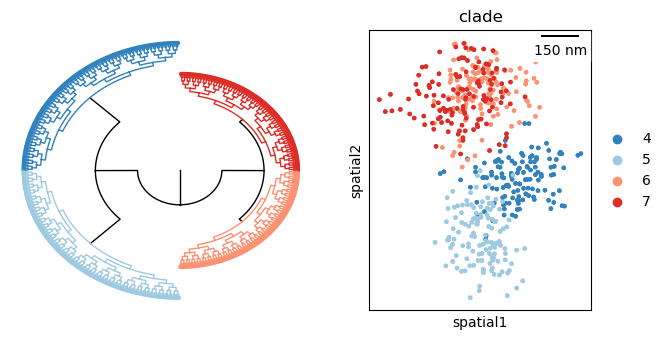

In [661]:
# Scale branch lengths of clade
# Get all parent-child relationships below a node

# TODO: use rejection sampling to ensure the data matches the mode
n_samples = 100


modes = {
    '1': {'2': .1, '3': .1},
    '2': {'4': .1, '5': .1, '6': .1, '7': .1},
    '3': {'4': .1, '5': .1, '3': .1},
    '4': {'1': 1.},
}
mode = '3'
# clade_rescale = {'4': .1, '5': .1, '6': .1, '7': .1}
# clade_rescale = {'2': .1, '3': .1}
simulated_tree = tree_simulator.simulate_tree()
clade_leaves = {}
for clade, scale in modes[mode].items():
    clade_leaves[clade] = simulated_tree.leaves_in_subtree(clade)

for clade in modes[mode]:
    branch_lengths = {}
    for p, c in simulated_tree.breadth_first_traverse_edges(clade):
        branch_lengths = simulated_tree.get_branch_length(p,c) * modes[mode][clade]
        simulated_tree.set_branch_length(p, c, branch_lengths)

spatial_simulator = space_simulator.BrownianSpatialDataSimulator(2, 1.)
spatial_simulator.overlay_data(simulated_tree, clades=list(clade_leaves.values()), rates=list(modes[mode].values()), brownian_motion=True, lambda_brownian=1.)

# # relabel nodes
# node_map = {l: f'cell{l}' for l in simulated_tree.leaves}
# simulated_tree.relabel_nodes(node_map)
# simulated_tree.character_matrix.index = [f'cell{l}' for l in simulated_tree.character_matrix.index]
# simulated_tree.cell_meta.index = simulated_tree.cell_meta.index.map(node_map)

simulated_adata = anndata.AnnData(obs=pd.DataFrame(index=simulated_tree.leaves))
simulated_adata.obs['library_id'] = 'simulated_puck'

simulated_adata.obsm['spatial'] = simulated_tree.cell_meta[['spatial_0', 'spatial_1']].to_numpy()        

utils.plot_selection(simulated_tree, simulated_adata, ['4', '5', '6', '7'], ['#3182bd', '#9ecae1', '#fc9272', '#de2d26'], orient=90)

In [662]:
# Reset the tree branches
for clade in modes[mode]:
    branch_lengths = {}
    for p, c in simulated_tree.breadth_first_traverse_edges(clade):
        branch_lengths = simulated_tree.get_branch_length(p,c) * 1./modes[mode][clade]
        simulated_tree.set_branch_length(p, c, branch_lengths)

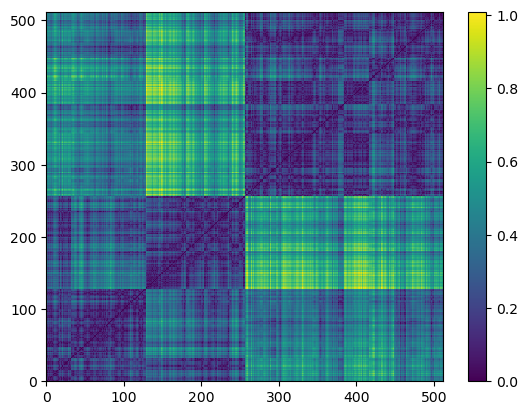

In [663]:
spatial_locs = simulated_tree.cell_meta[['spatial_0', 'spatial_1']]
spatial_distance_matrix = pd.DataFrame(
                                        squareform(pdist(spatial_locs, metric='euclidean')), 
                            index=spatial_locs.index, columns=spatial_locs.index)
plt.pcolormesh(spatial_distance_matrix.loc[ex_simulator.leaf_names, :][ex_simulator.leaf_names])
plt.colorbar()
plt.show()

## Simulate single-cell gene expression profiles
Using a trait model on the tree and tree-indepedent spatial effects  

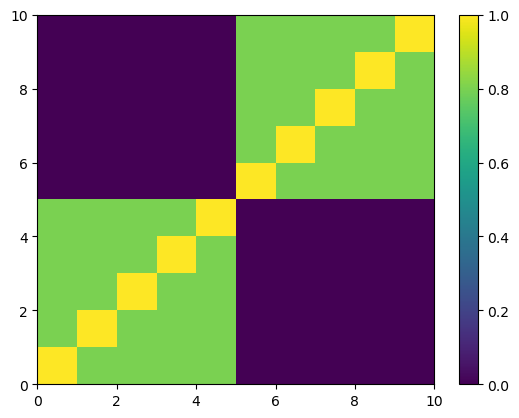

In [664]:
# Brownian Motion model on the tree
n_genes = 10

# Create two blocks of highly correlated genes (block diagonal covariance)
block_size = n_genes // 2
block1 = np.ones((block_size, block_size)) * 0.8 + np.eye(block_size) * 0.2 
block2 = np.ones((n_genes - block_size, n_genes - block_size)) * 0.8 + np.eye(n_genes - block_size) * 0.2
trait_covariances = np.zeros((n_genes, n_genes))
trait_covariances[:block_size, :block_size] = block1
trait_covariances[block_size:, block_size:] = block2
trait_covariances = trait_covariances / 1.

trait_covariances = pd.DataFrame(trait_covariances, index=["G" + str(i) for i in range(n_genes)], columns=["G" + str(i) for i in range(n_genes)])
plt.pcolormesh(trait_covariances)
plt.colorbar()
plt.show()

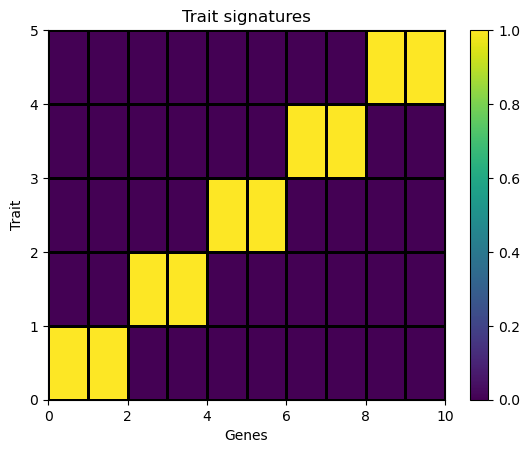

In [722]:
# Traits as gene programs
n_genes = 10
n_traits = 5
# Each row is a gene program (signature), each column is a gene
# 1 indicates the gene is active in that program, 0 otherwise
np.random.seed(0)
trait_signatures = np.zeros((n_traits, n_genes))
# Make non-overlapping gene programs: each gene belongs to only one program
genes = np.arange(n_genes)
# np.random.shuffle(genes)
split_genes = np.array_split(genes, n_traits)
for k, gene_indices in enumerate(split_genes):
    trait_signatures[k, gene_indices] = 1

trait_signatures = pd.DataFrame(trait_signatures, index=["T" + str(i) for i in range(n_traits)], columns=["G" + str(i) for i in range(n_genes)])
plt.pcolormesh(trait_signatures, edgecolor='black')
plt.colorbar()
plt.title('Trait signatures')
plt.xlabel('Genes')
plt.ylabel('Trait')
plt.show()


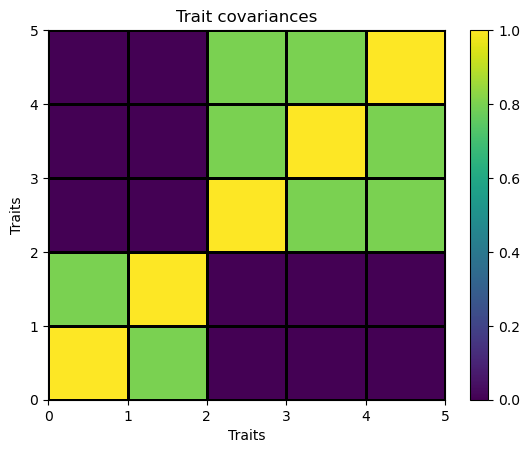

In [724]:
# Brownian Motion model on the tree

# Create two blocks of highly correlated genes (block diagonal covariance)
block_size = n_traits // 2
block1 = np.ones((block_size, block_size)) * 0.8 + np.eye(block_size) * 0.2 
block2 = np.ones((n_traits - block_size, n_traits - block_size)) * 0.8 + np.eye(n_traits - block_size) * 0.2
trait_covariances = np.zeros((n_traits, n_traits))
trait_covariances[:block_size, :block_size] = block1
trait_covariances[block_size:, block_size:] = block2
trait_covariances = trait_covariances / 1.

trait_covariances = pd.DataFrame(trait_covariances, index=["T" + str(i) for i in range(n_traits)], columns=["T" + str(i) for i in range(n_traits)])
plt.pcolormesh(trait_covariances, edgecolor='black')
plt.xlabel('Traits')
plt.ylabel('Traits')
plt.title('Trait covariances')
plt.colorbar()
plt.show()

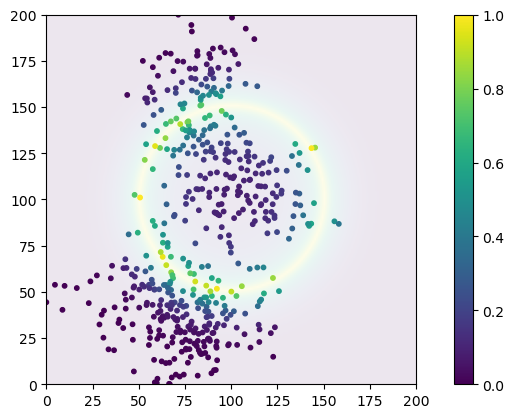

In [667]:
# A continuous spatial effect
spatial_activation = visium_simulator.prior(200, visium_simulator.circ_equation, decay_factor=.001, radius=50, center_x=100, center_y=100)
gene_program = np.zeros((n_genes,))
gene_program[np.random.choice(n_genes, size=5)] = 1. # activate these genes

x = simulated_adata[spatial_simulator.leaf_names].obsm['spatial'][:, 0]
y = simulated_adata[spatial_simulator.leaf_names].obsm['spatial'][:, 1]

# Map scatter points to heatmap indices
nx, ny = spatial_activation.shape
xi = (x / 1 * (nx - 1)).astype(int)
yi = (y / 1 * (ny - 1)).astype(int)
# Get heatmap values for each point
cvals = spatial_activation[yi, xi]
# Scatter colored by heatmap values
sc = plt.scatter(x * 200, y * 200, c=cvals, cmap="viridis", s=10, vmax=1, vmin=0)
plt.colorbar()
# Show the heatmap in the background too
plt.imshow(
    spatial_activation,
    extent=[0, 200, 0, 200],
    origin="lower",
    cmap="viridis",
    alpha=0.1
)
plt.axis('square')

plt.show()

In [678]:
len(subclades)

4

In [729]:
# Generate single-cell expression profiles
clades = [simulated_tree.leaves_in_subtree(simulated_tree.children('1')[0]),
        simulated_tree.leaves_in_subtree(simulated_tree.children('1')[1])]
rates = [1., 1.]

ex_simulator = expression_simulator.ExpressionSimulator(trait_covariances, trait_signatures, spatial_activation, gene_program)
ex_simulator.overlay_data(simulated_tree, alpha=1.0, clades=subclades, rates=[.1]*len(subclades)) # 0: fully external factors, 1: fully tree
expression = simulated_tree.cell_meta[[f'G{i}' for i in range(ex_simulator.n_genes)]].loc[ex_simulator.leaf_names]#.to_numpy()
trait_activations = simulated_tree.cell_meta[[f'T{i}' for i in range(ex_simulator.n_traits)]].loc[ex_simulator.leaf_names]


In [730]:
np.exp(trait_activations) / np.sum(np.exp(trait_activations), axis=1).values[:, None]

T0        T1        T2        T3        T4
512   0.261145  0.175966  0.179045  0.189974  0.193870
513   0.298708  0.178098  0.170789  0.175188  0.177216
514   0.290645  0.179837  0.168282  0.176178  0.185059
515   0.307647  0.176542  0.165509  0.172253  0.178048
516   0.255638  0.179360  0.178919  0.201069  0.185013
...        ...       ...       ...       ...       ...
1019  0.172526  0.324395  0.169809  0.164902  0.168369
1020  0.171159  0.333681  0.165713  0.161393  0.168054
1021  0.178092  0.314922  0.166456  0.165465  0.175066
1022  0.164626  0.357425  0.161065  0.156914  0.159970
1023  0.167433  0.347508  0.163455  0.159547  0.162058

[512 rows x 5 columns]

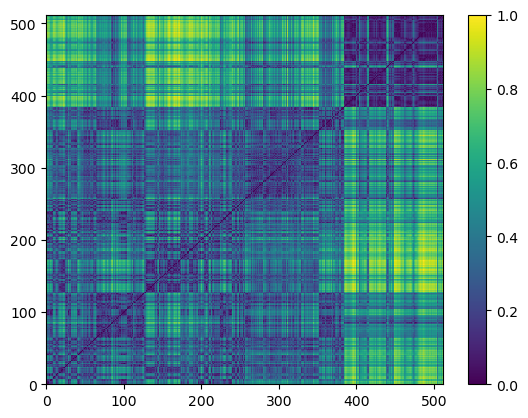

In [731]:
ss_distance_matrix = squareform(pdist(trait_activations, metric='euclidean'))
ss_distance_matrix = ss_distance_matrix / ss_distance_matrix.max()
plt.pcolormesh(ss_distance_matrix)
plt.colorbar()
plt.show()


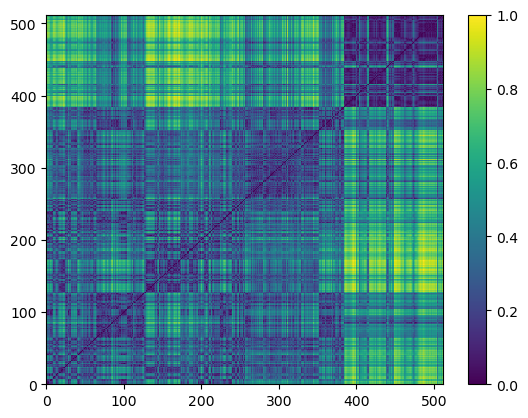

In [732]:
ss_distance_matrix = squareform(pdist(expression, metric='euclidean'))
ss_distance_matrix = ss_distance_matrix / ss_distance_matrix.max()
plt.pcolormesh(ss_distance_matrix)
plt.colorbar()
plt.show()


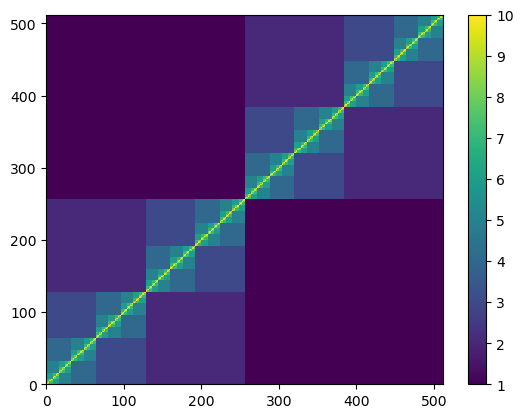

In [733]:
plt.pcolormesh(ex_simulator.leaf_cov_matrix)
plt.colorbar()
plt.show()

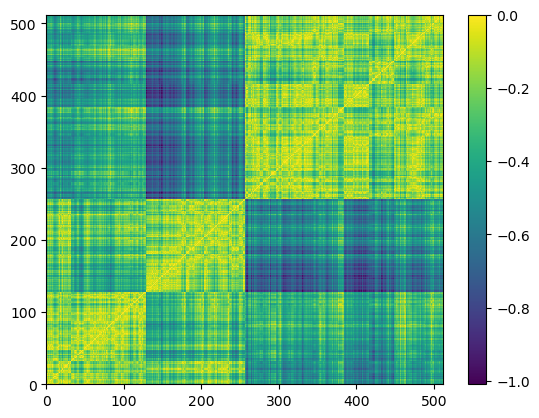

In [734]:
spatial_distance_matrix = squareform(-pdist(simulated_adata[ex_simulator.leaf_names].obsm['spatial'], metric='euclidean'))
plt.pcolormesh(spatial_distance_matrix)
plt.colorbar()
plt.show()

## Single-cell RNA-sequencing data simulation

In [735]:
# Simulate single-cell gene expression data
ss_cell_library_sizes = np.random.poisson(1000, size=ex_simulator.n_leaves) * 0 + 1
ss_gene_sizes = np.random.poisson(100, size=ex_simulator.n_genes) * 0 + 1
ss_transcriptomes = np.random.normal(expression, .1)#np.random.poisson(np.exp(expression) * ss_cell_library_sizes[:, None] * ss_gene_sizes[None, :])
ss_simulated_adata = anndata.AnnData(pd.DataFrame(ss_transcriptomes, index=expression.index, columns=expression.columns))
ss_simulated_adata.raw = ss_simulated_adata.copy()
ss_simulated_adata.obs['library_id'] = 'simulated_puck'
ss_simulated_adata.obsm['spatial'] = simulated_tree.cell_meta[['spatial_0', 'spatial_1']].loc[expression.index].to_numpy()
for trait in ex_simulator.trait_names:
    ss_simulated_adata.obs[trait] = trait_activations[trait]


In [736]:
# Top clades
top_clades = simulated_tree.children(simulated_tree.root)
for i, clade in enumerate(top_clades):
    leaves = simulated_tree.leaves_in_subtree(clade)
    ss_simulated_adata.obs.loc[leaves, 'clade_level0'] = 'clade' + str(clade)
    for j, subclade in enumerate(simulated_tree.children(clade)):
        subclade_leaves = simulated_tree.leaves_in_subtree(subclade)
        ss_simulated_adata.obs.loc[subclade_leaves, 'clade_level1'] = 'clade' + str(subclade)
        for k, subsubclade in enumerate(simulated_tree.children(subclade)):
            subsubclade_leaves = simulated_tree.leaves_in_subtree(subsubclade)
            ss_simulated_adata.obs.loc[subsubclade_leaves, 'clade_level2'] = 'clade' + str(subsubclade)

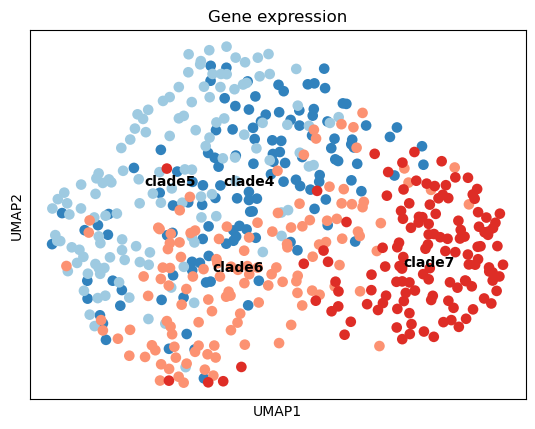

In [739]:
# Show clade in UMAP
import scanpy as sc
sc.pp.log1p(ss_simulated_adata)
sc.pp.pca(ss_simulated_adata)
sc.pp.neighbors(ss_simulated_adata)
sc.tl.umap(ss_simulated_adata)
ss_simulated_adata.uns['clade_level2_colors'] = ['#3182bd', '#9ecae1', '#fc9272', '#de2d26']
sc.pl.umap(ss_simulated_adata, color=['clade_level2'] , title='Gene expression', legend_loc='on data')

/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/squidpy/pl/_spatial_utils.py:976: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


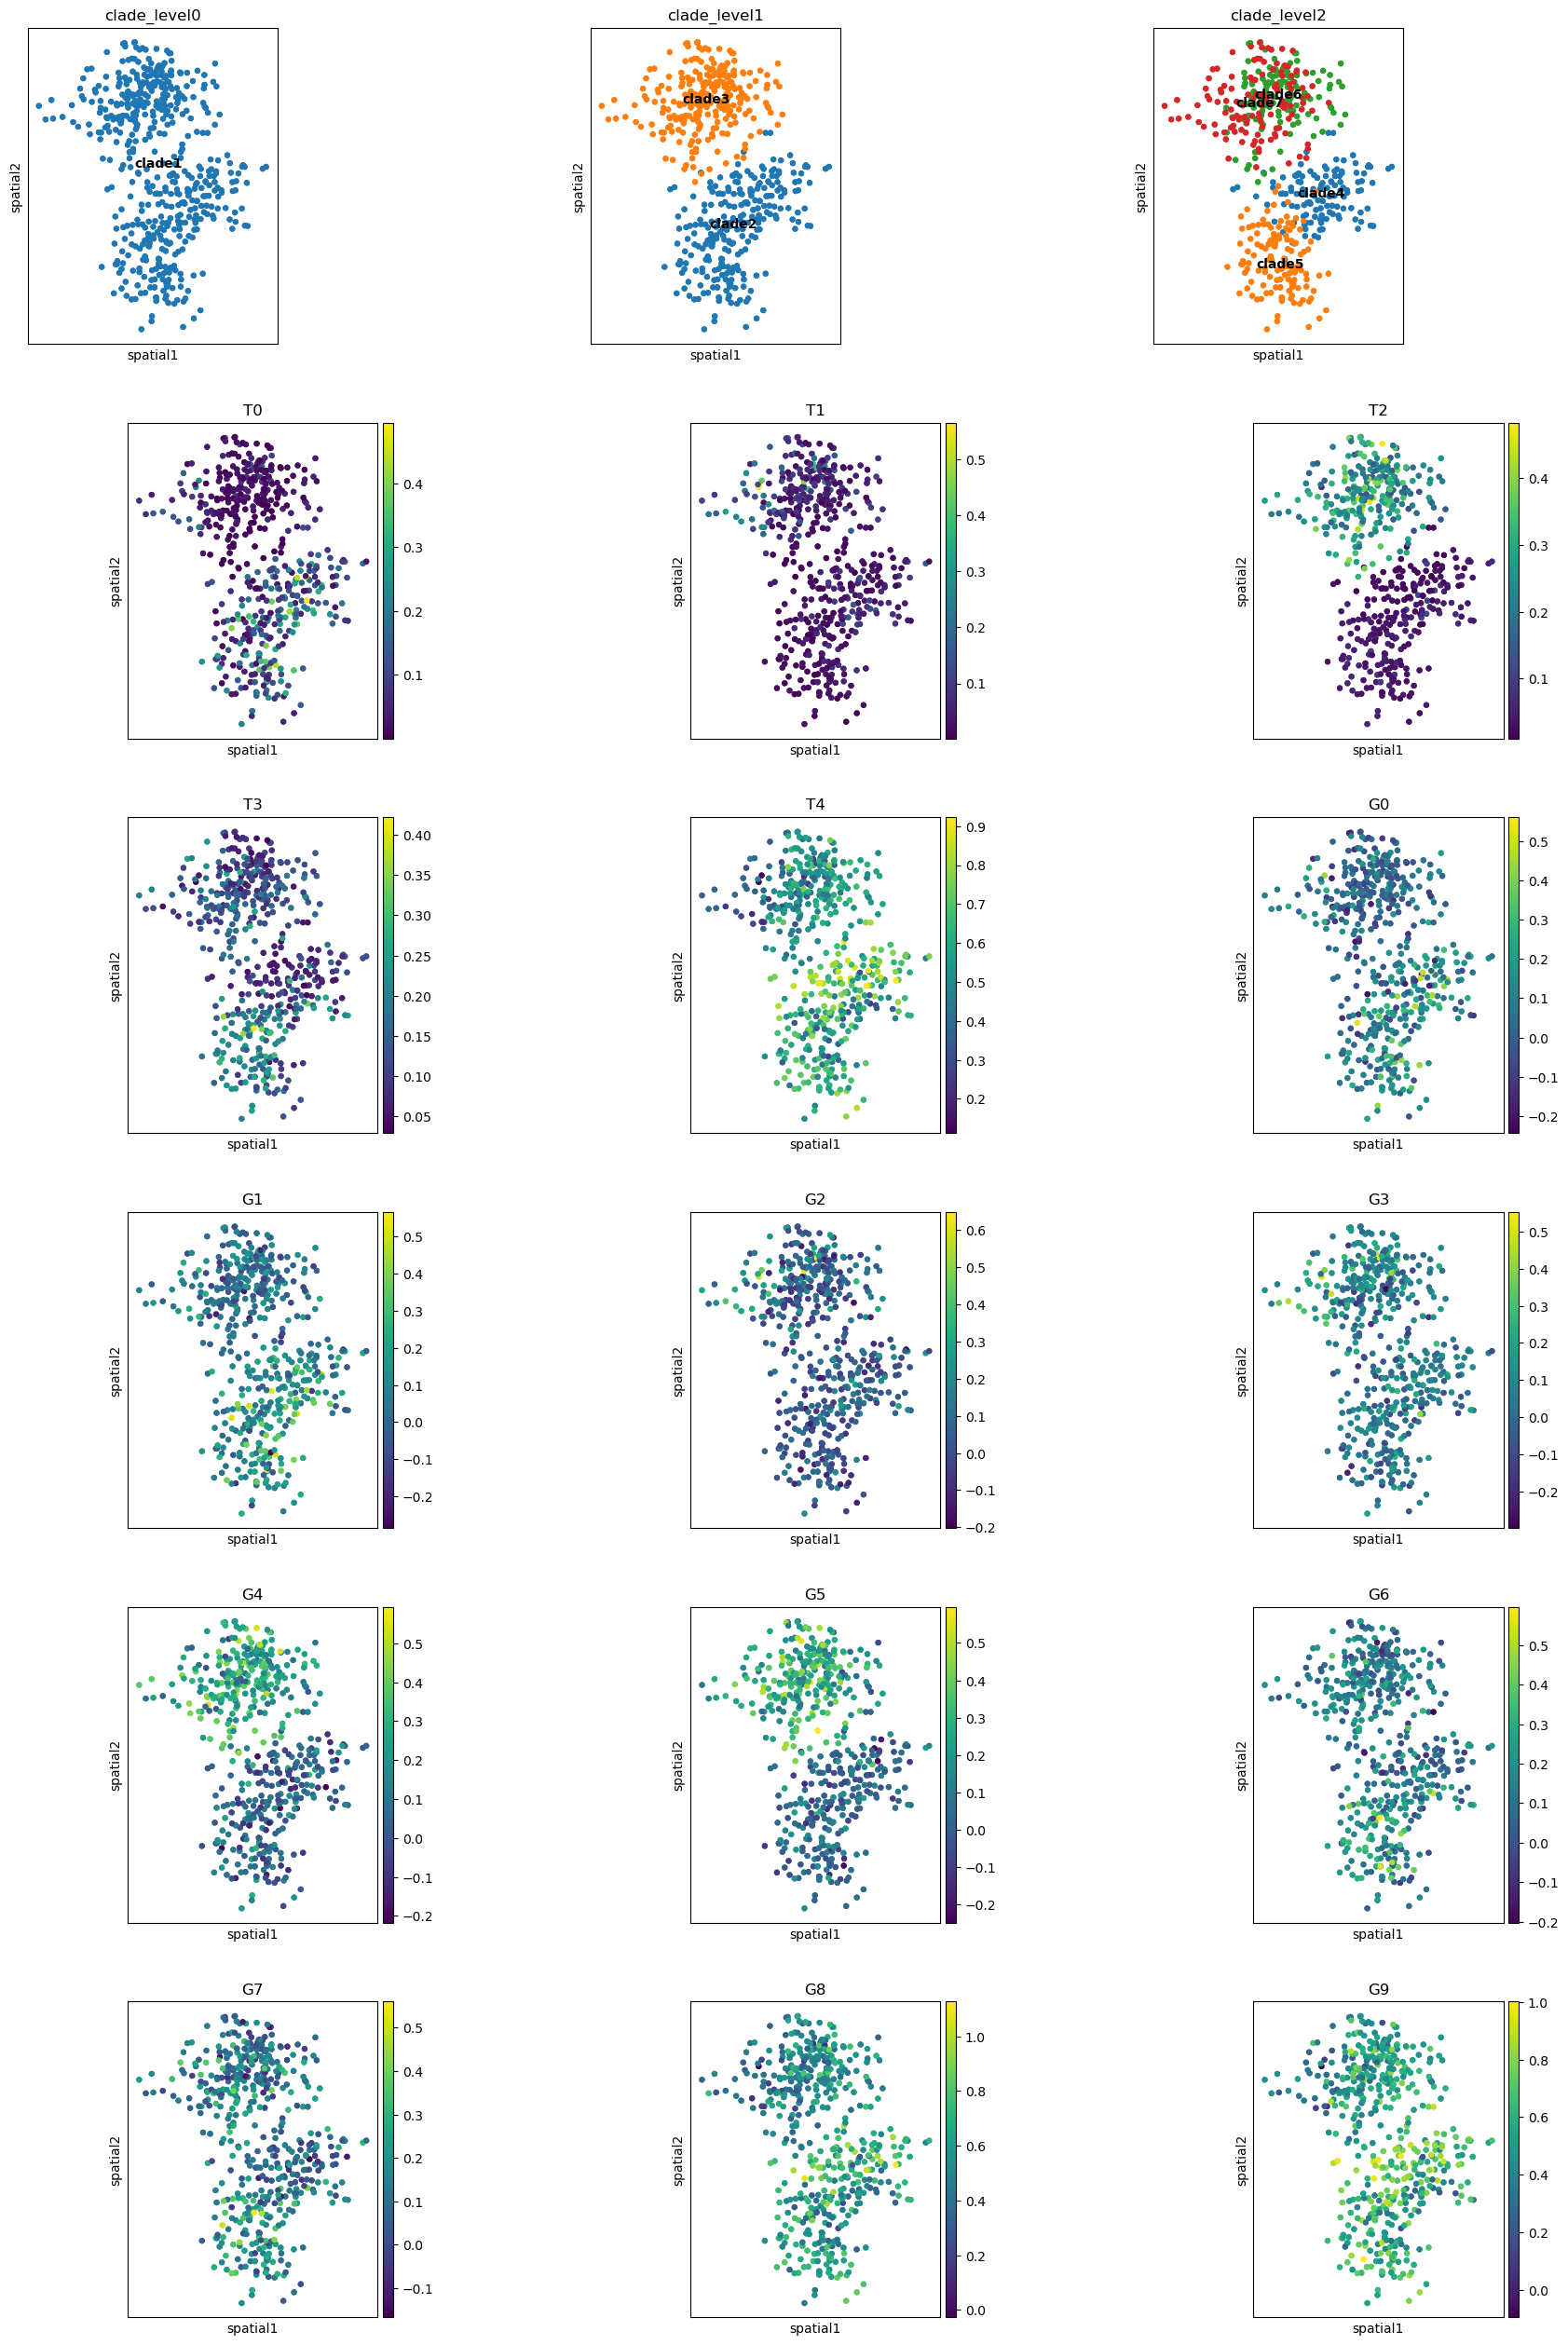

In [687]:
sq.pl.spatial_scatter(ss_simulated_adata, color=['clade_level0', 'clade_level1', 'clade_level2'] + [f'T{i}' for i in range(ex_simulator.n_traits)] + [f'G{i}' for i in range(ex_simulator.n_genes)], library_id='puck1',
                    size=50, shape=None, legend_loc='on data', ncols=3)

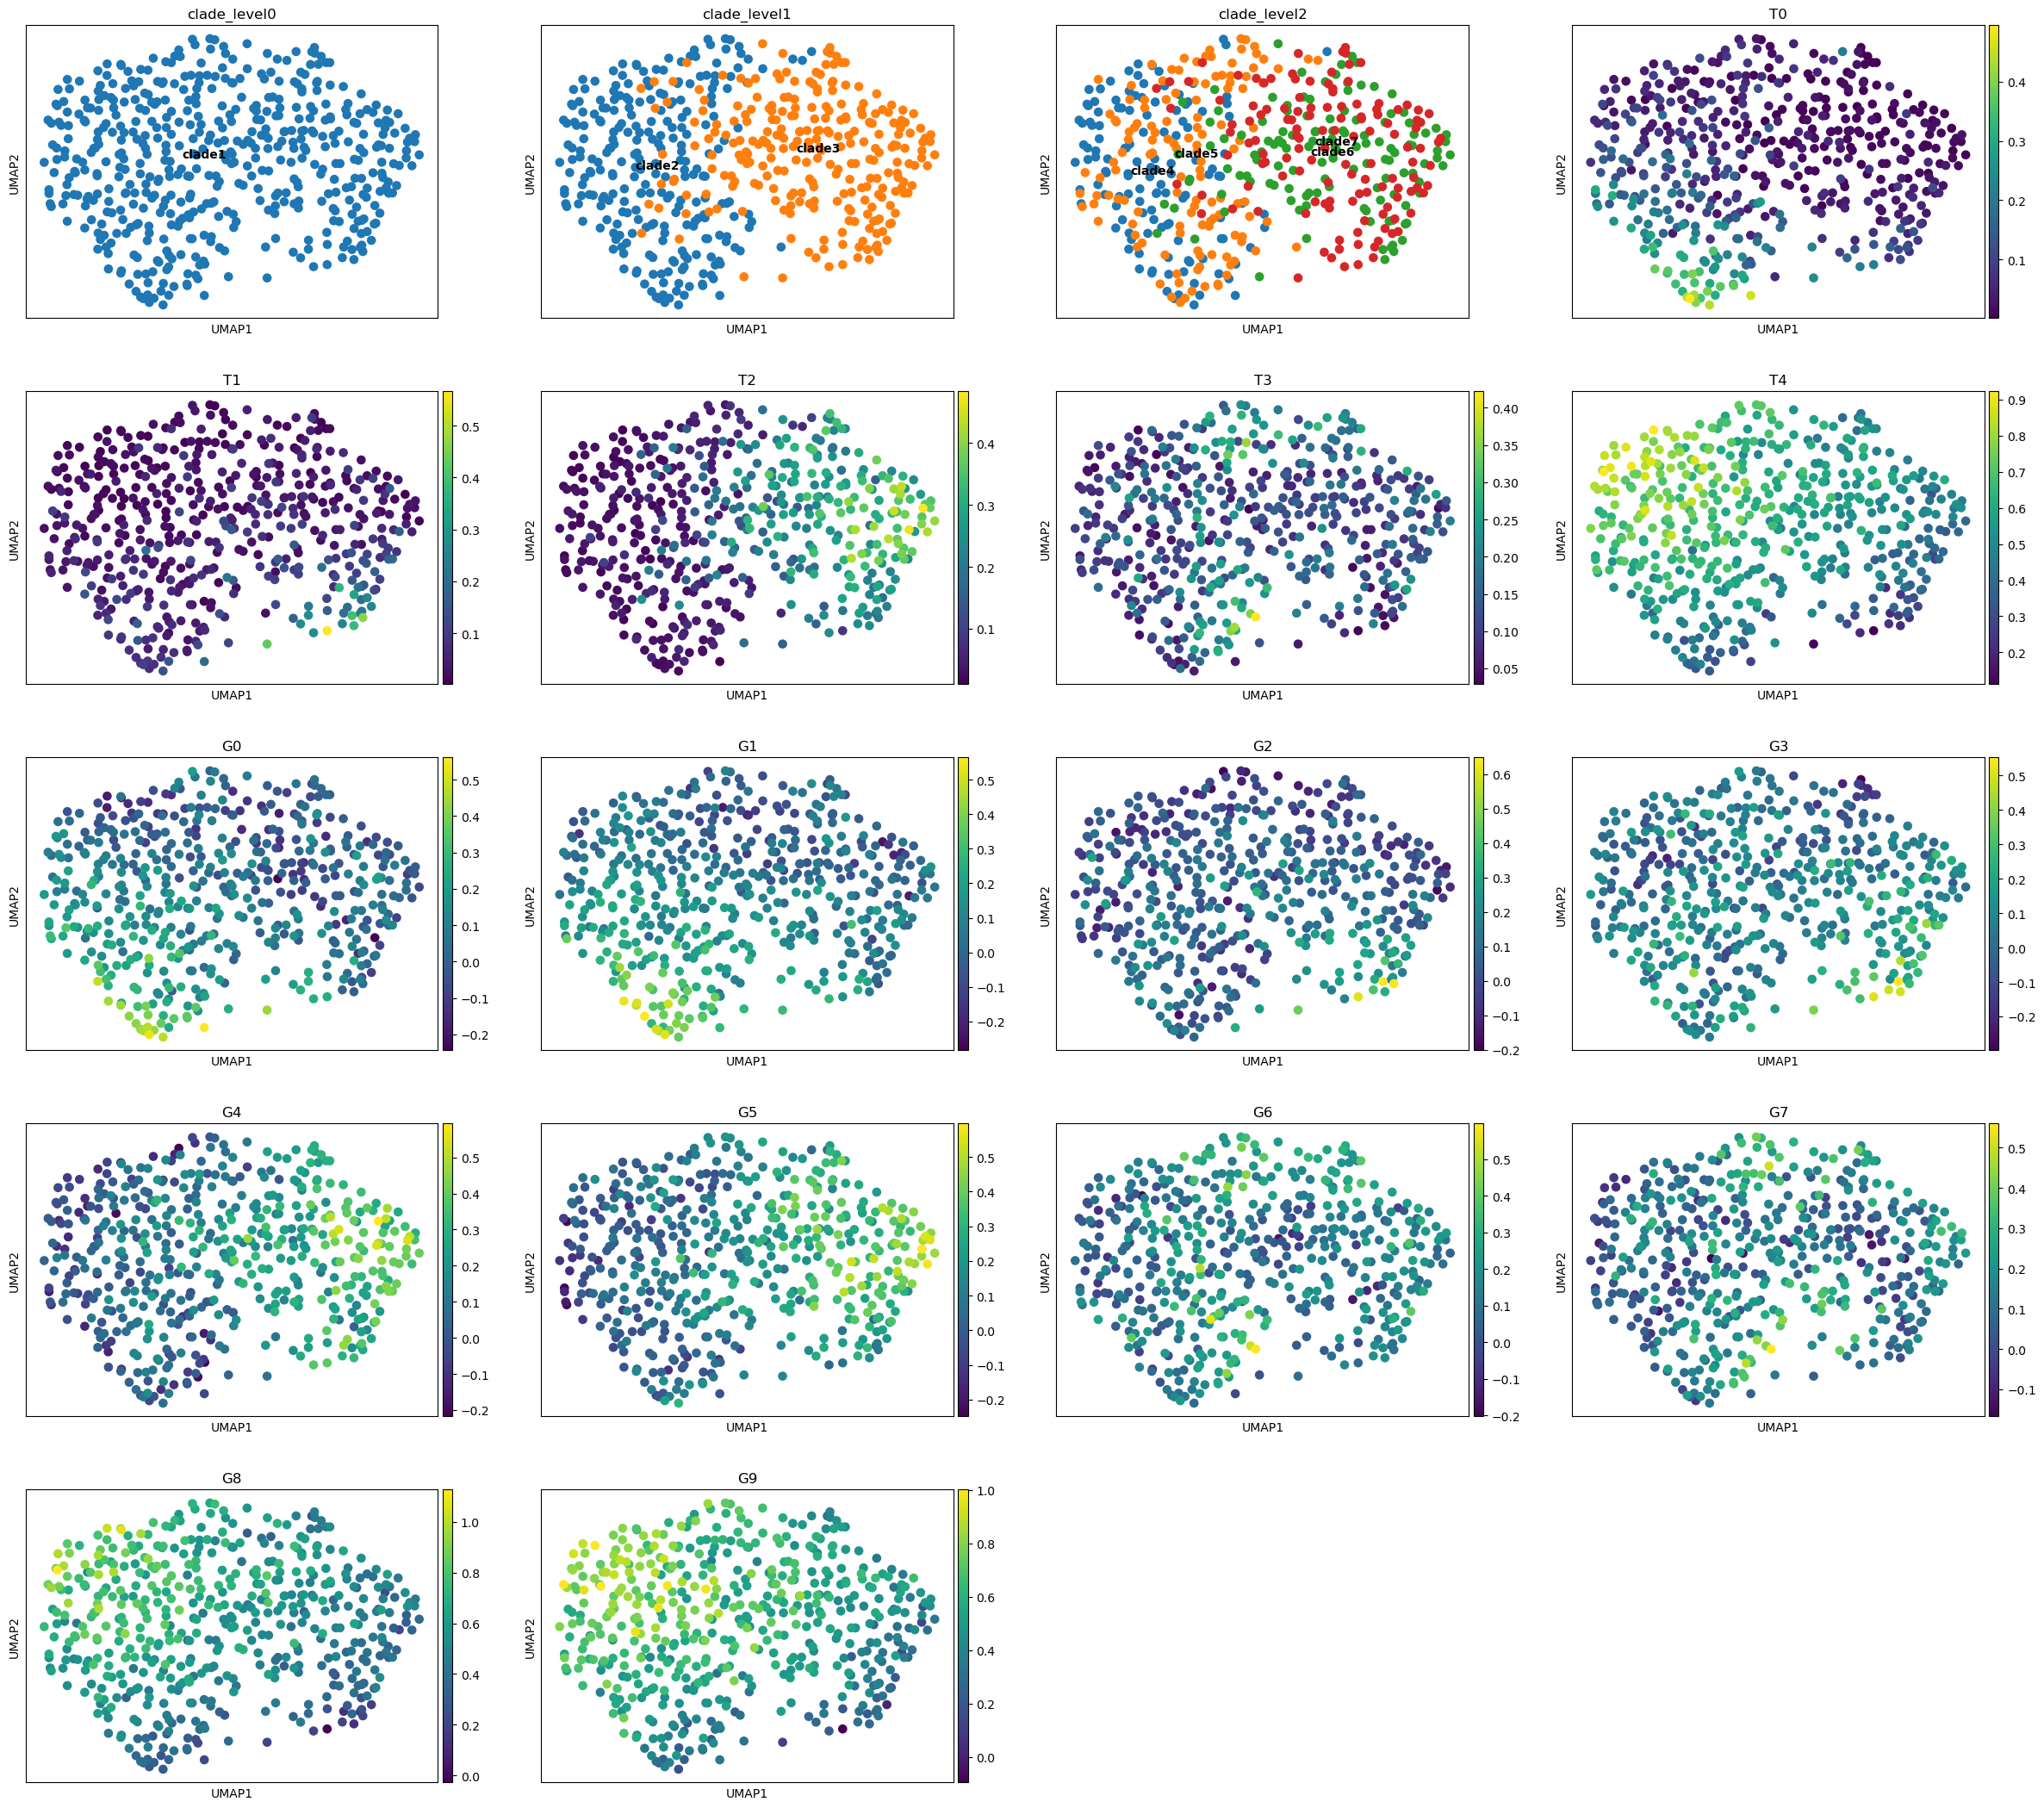

In [688]:
# Show clade in UMAP
import scanpy as sc
sc.pp.log1p(ss_simulated_adata)
sc.pp.pca(ss_simulated_adata)
sc.pp.neighbors(ss_simulated_adata)
sc.tl.umap(ss_simulated_adata)
sc.pl.umap(ss_simulated_adata, color=['clade_level0', 'clade_level1', 'clade_level2'] + ex_simulator.trait_names + ex_simulator.gene_names, legend_loc='on data')

## Spatial transcriptomics data simulation

In [362]:
gx, gy = visium_simulator.map_points_to_grid_lowerleft(
    x, y,
    xmin=0.0, ymin=0.0, 
    dx=.05, dy=0.05
)

In [363]:
cell_spot_locations = np.c_[gx, gy]
spots = np.unique(cell_spot_locations, axis=0)
# Make a vector of cell to spot names indicating which spot each cell belongs to
# For each cell, find the index of its spot in the unique spots array, then assign the corresponding spot name
cells_to_spots = np.array([
    f'spot_{np.where((spots == loc).all(axis=1))[0][0]}' for loc in cell_spot_locations
])


In [598]:
# Simulate spatial gene expression data
n_spots = spots.shape[0]
spot_expression = np.zeros((n_spots, n_genes))
spot_trait_activations = np.zeros((n_spots, n_traits))
spot_names = [f'spot_{i}' for i in range(n_spots)]
cells_in_spots = []
clades_fractions = []
clades_assignments = []
for spot in range(n_spots):
    spot_cells = np.where(cells_to_spots == f'spot_{spot}')[0]
    spot_expression[spot] = np.mean(expression.iloc[spot_cells], axis=0) # all transcripts
    spot_trait_activations[spot] = np.mean(trait_activations.iloc[spot_cells], axis=0) # all traits
    cells_in_spots.append(expression.iloc[spot_cells].index)
    clades_fractions.append(ss_simulated_adata.obs.loc[expression.iloc[spot_cells].index, 'clade_level2'].value_counts()/len(spot_cells))
    clades_assignments.append(ss_simulated_adata.obs.loc[expression.iloc[spot_cells].index, 'clade_level2'].value_counts().idxmax())
spatial_spot_library_sizes = np.random.poisson(1000, size=n_spots) * 0 + 1
spatial_spot_gene_sizes = np.random.poisson(100, size=n_genes) * 0 + 1
spatial_transcriptomes = np.random.normal(spot_expression, .01)#np.random.poisson(np.exp(spot_expression) * spatial_spot_library_sizes[:, None] * spatial_spot_gene_sizes[None, :])
spatial_simulated_adata = anndata.AnnData(pd.DataFrame(spatial_transcriptomes, index=spot_names, columns=ex_simulator.gene_names))
spatial_simulated_adata.obsm['spatial'] = spots
spatial_simulated_adata.obsm['clade_level2_fractions'] = pd.DataFrame(clades_fractions, index=spot_names, columns=ss_simulated_adata.obs['clade_level2'].unique()).loc[spatial_simulated_adata.obs.index].values
spatial_simulated_adata.obs['clade_level2'] = clades_assignments

spot_trait_activations = pd.DataFrame(spot_trait_activations, index=spot_names, columns=ex_simulator.trait_names)
for trait in ex_simulator.trait_names:
    spatial_simulated_adata.obs[trait] = spot_trait_activations[trait]

spatial_simulated_adata = spatial_simulated_adata[spatial_simulated_adata.obs['clade_level2'].sort_values().index]
spatial_simulated_adata

View of AnnData object with n_obs × n_vars = 147 × 10
    obs: 'clade_level2', 'T0', 'T1', 'T2', 'T3', 'T4'
    obsm: 'spatial', 'clade_level2_fractions'

In [600]:
spatial_simulated_adata

View of AnnData object with n_obs × n_vars = 147 × 10
    obs: 'clade_level2', 'T0', 'T1', 'T2', 'T3', 'T4'
    obsm: 'spatial', 'clade_level2_fractions'

/var/folders/d4/tfj5y66n2zzddb2k40xhyhk80000gp/T/ipykernel_80394/1210994467.py:2: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(spatial_simulated_adata, color=ex_simulator.trait_names + ['clade_level2'] + ex_simulator.gene_names, spot_size=.05)
/Users/pedroferreira/miniconda3/envs/phylospatial/lib/python3.10/site-packages/anndata/_core/anndata.py:1138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


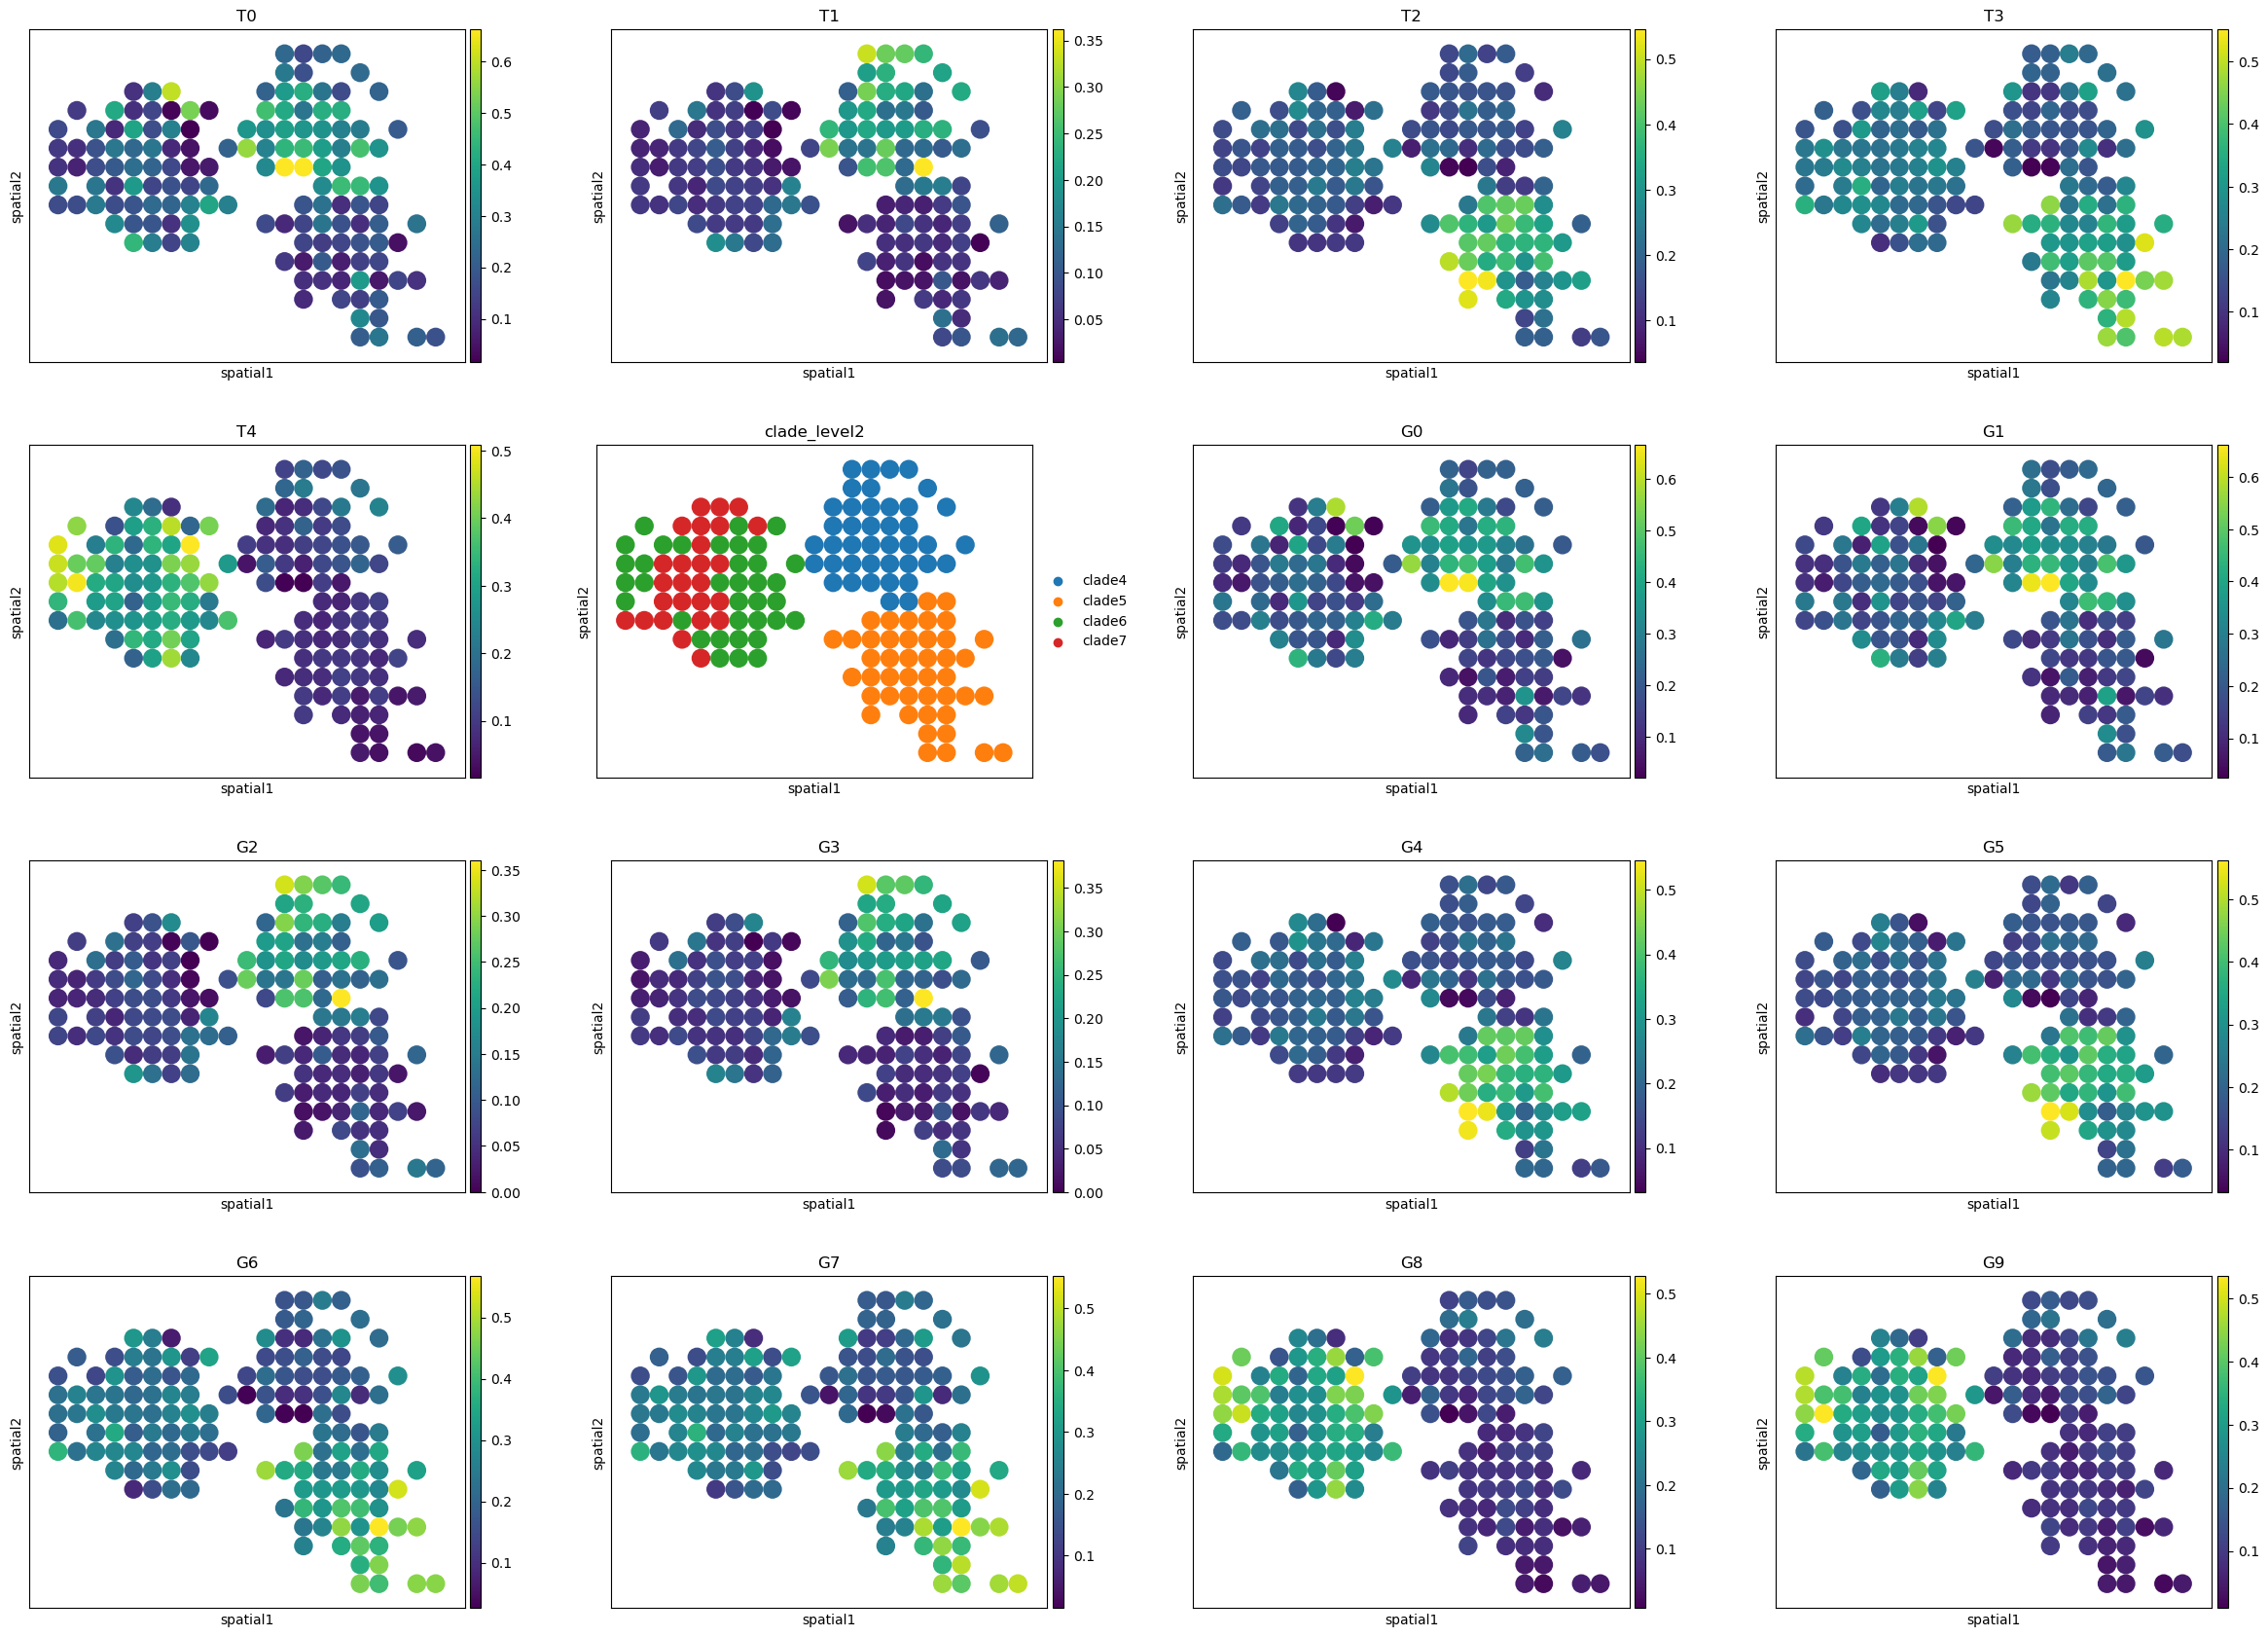

In [601]:
# Look at the spatial data
sc.pl.spatial(spatial_simulated_adata, color=ex_simulator.trait_names + ['clade_level2'] + ex_simulator.gene_names, spot_size=.05)

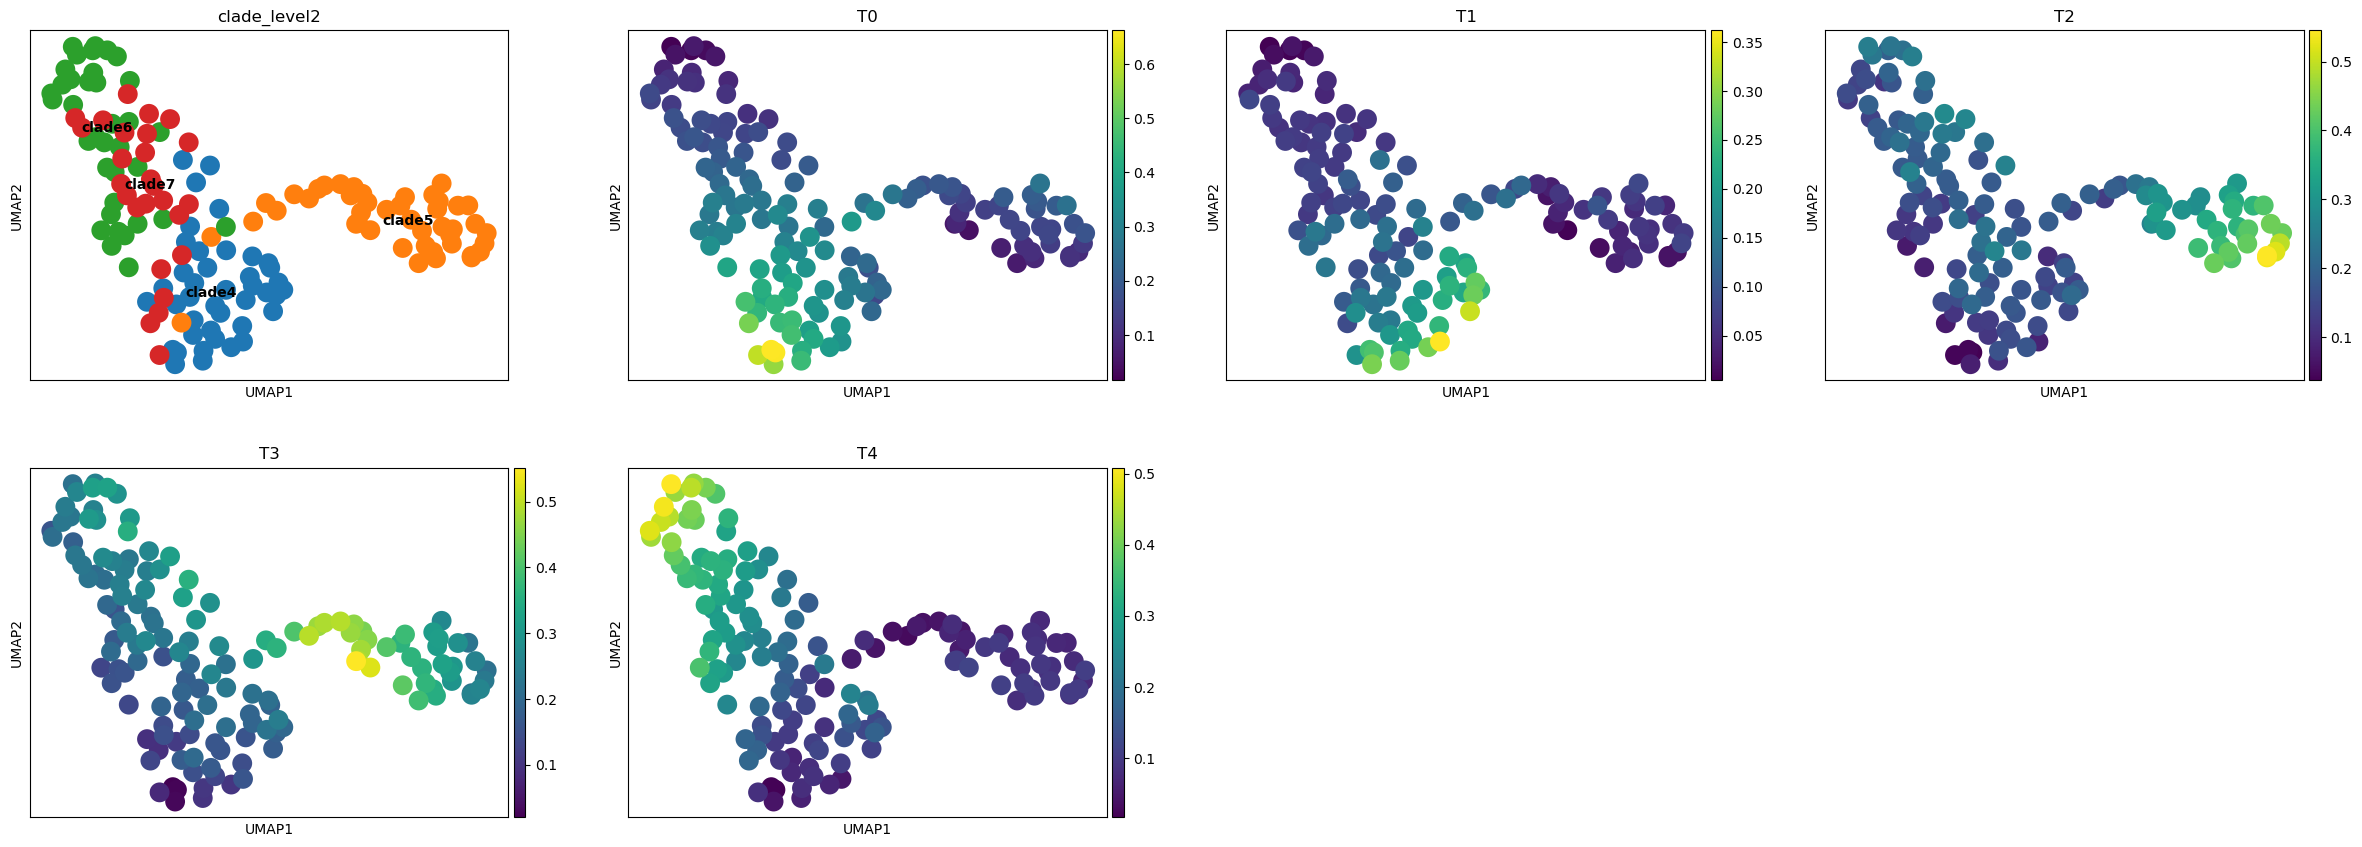

In [602]:
# Show clade in UMAP
import scanpy as sc
sc.pp.log1p(spatial_simulated_adata)
sc.pp.pca(spatial_simulated_adata)
sc.pp.neighbors(spatial_simulated_adata)
sc.tl.umap(spatial_simulated_adata)
sc.pl.umap(spatial_simulated_adata, color=['clade_level2'] + ex_simulator.trait_names, legend_loc='on data')

In [ ]:
spot_distance_matrix = squareform(pdist(spatial_simulated_adata.X, metric='euclidean'))
spot_distance_matrix = spot_distance_matrix# / spot_distance_matrix.max()
plt.pcolormesh(spot_distance_matrix)
plt.colorbar()
plt.show()


## Map the single-cell data to the spatial data

In [ ]:
true_couplings = np.zeros((ss_simulated_adata.shape[0], spatial_simulated_adata.shape[0]))
for i, cell in enumerate(ss_simulated_adata.obs.index):
    spot = cells_to_spots[i]
    spot_idx = np.where(spatial_simulated_adata.obs.index == spot)[0][0]
    true_couplings[i, spot_idx] = 1
plt.pcolormesh(true_couplings)
plt.colorbar()
plt.show()


In [373]:
# Get distance matrices
tree_distance_matrix = cas.data.compute_phylogenetic_weight_matrix(simulated_tree) 
tree_distance_matrix = tree_distance_matrix.loc[ex_simulator.leaf_names, :][ex_simulator.leaf_names]
tree_distance_matrix = tree_distance_matrix / tree_distance_matrix.max()

spatial_distance_matrix = squareform(pdist(spatial_simulated_adata.obsm['spatial'], metric='euclidean'))
spatial_distance_matrix = spatial_distance_matrix / spatial_distance_matrix.max()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

im1 = axs[0].pcolormesh(tree_distance_matrix)
axs[0].set_title('Tree Distance Matrix')
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].pcolormesh(spatial_distance_matrix)
axs[1].set_title('Spatial Distance Matrix')
fig.colorbar(im2, ax=axs[1])

plt.tight_layout()
plt.show()


### Correlation-based

In [562]:
# Assign each cell to the spot with the highest correlation
coupling = mappers.pairwise_correlations(np.asarray(ss_simulated_adata.X), np.asarray(spatial_simulated_adata.X))
correlation_assignments = np.argmax(coupling, axis=1)
correlation_assignments = spatial_simulated_adata.obs.index[correlation_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(correlation_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")


Assignment accuracy: 0.037


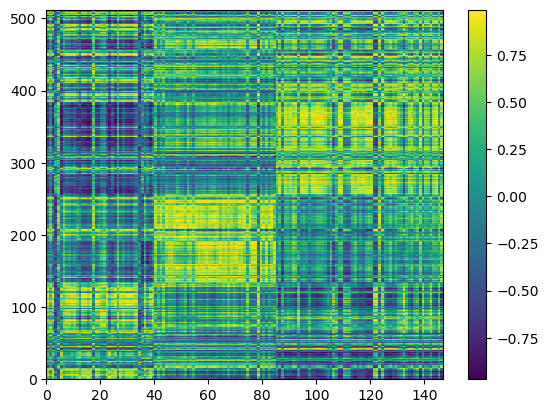

In [563]:
plt.pcolormesh(coupling)
plt.colorbar()

In [564]:
# build sets of true cells per spot
S = {f'spot_{j}': np.where(cells_to_spots == f'spot_{j}')[0] for j in range(n_spots)}

# per-cell distance to assigned spot (min to that spot’s true cells)
delta = np.array([
    tree_distance_matrix.values[i, S[correlation_assignments[i]]].min()
    for i in range(correlation_assignments.shape[0])
])

mean_tree_dist = delta.mean()
mean_tree_dist

np.float64(0.6551649305555556)

/var/folders/d4/tfj5y66n2zzddb2k40xhyhk80000gp/T/ipykernel_80394/2038919606.py:9: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)


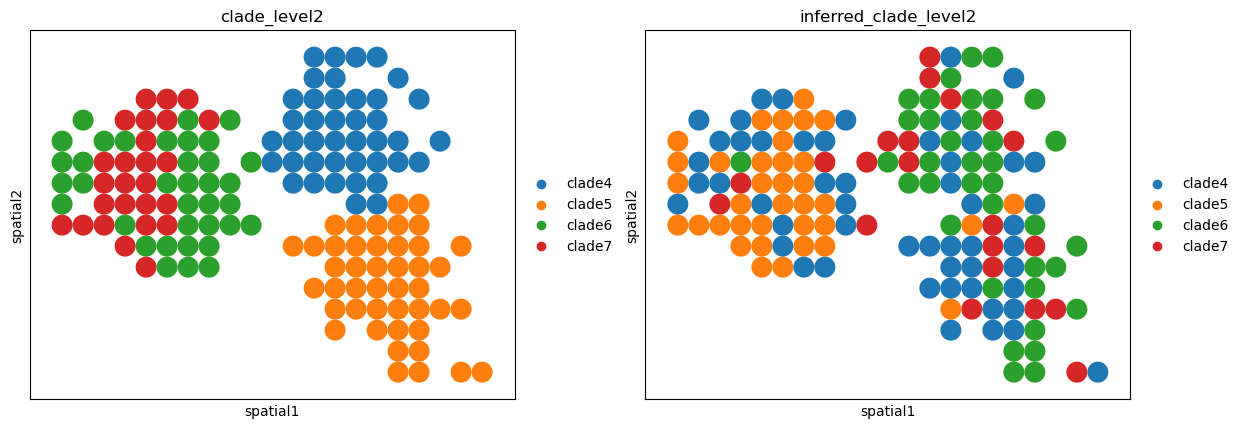

In [565]:
inferred_clades_assignments = []
for spot in range(n_spots):
    spot_cells = np.where(correlation_assignments == f'spot_{spot}')[0]
    inferred_clades_assignments.append(ss_simulated_adata.obs.loc[ss_simulated_adata.obs.index[spot_cells], 'clade_level2'].value_counts().idxmax())
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments

# Color the spatial data by the clade of the inferred cells assigned to each spot
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments
sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)

In [566]:
# Measure the accuracy of the inferred clades
true_clades = spatial_simulated_adata.obs['clade_level2']
predicted_clades = spatial_simulated_adata.obs['inferred_clade_level2']
clade_accuracy = np.mean(true_clades == predicted_clades)
print(f"Clade assignment accuracy: {clade_accuracy:.3f}")


Clade assignment accuracy: 0.102


In [ ]:
# Measure the accuracy of the inferred clades
true_clades = spatial_simulated_adata.obs['clade_level2']
predicted_clades = spatial_simulated_adata.obs['inferred_clade_level2']
clade_accuracy = np.mean(true_clades == predicted_clades)
print(f"Clade assignment accuracy: {clade_accuracy:.3f}")


## Optimal transport methods

In [416]:
file_path = os.path.join(os.getcwd(), "../src/", "spotr.py")
spec = importlib.util.spec_from_file_location("spotr", file_path)
spotr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(spotr)

In [ ]:
# Optimal transport utilities
import jax.numpy as jnp
import ot
X = jnp.asarray(ss_simulated_adata.X)
Y = jnp.asarray(spatial_simulated_adata.X)

K = trait_activations.shape[1]
cell_type_assignments = jnp.ones((X.shape[0], K))
cell_type_assignments = jnp.array(trait_activations.values) / jnp.sum(trait_activations.values, axis=1, keepdims=True)
cell_type_signatures = jnp.ones((K, Y.shape[1]))
cell_type_signatures = jnp.array(ex_simulator.trait_signatures.values)


a = jnp.ones(X.shape[0]) / X.shape[0]
b = jnp.ones(Y.shape[0]) / Y.shape[0]
C_tree = jnp.asarray(tree_distance_matrix) #jnp.array(1-np.identity(tree_distance_matrix.shape[0]))#
C_space = jnp.asarray(spatial_distance_matrix) # jnp.array(1-np.identity(spatial_distance_matrix.shape[0]))
C_feature = jnp.array(ot.dist(np.array(X), np.array(Y)))
C_feature = C_feature / C_feature.max()
gamma0 = (a[:, None] * b[None, :]) 

sF_ref = spotr.mad_abs(spotr.dc(C_feature,a,b))                      # fixed
sL_ref = spotr.mad_abs(spotr.dc(spotr.compute_Lgw(C_tree,C_space,a,b,gamma0),a,b))  # at a reference gamma_ref
C_gw = spotr.build_fgw_cost(1., C_feature, C_tree, C_space, a, b, gamma0, sF_ref, sL_ref)

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(15, 4))

im0 = axs[0].pcolormesh(np.array(C_feature), cmap='viridis')
axs[0].set_title('C_feature')
fig.colorbar(im0, ax=axs[0])

im1 = axs[1].pcolormesh(np.array(C_tree), cmap='viridis')
axs[1].set_title('C_tree')
fig.colorbar(im1, ax=axs[1])

im2 = axs[2].pcolormesh(np.array(C_space), cmap='viridis')
axs[2].set_title('C_space')
fig.colorbar(im2, ax=axs[2])

im3 = axs[3].pcolormesh(np.array(C_gw), cmap='viridis')
axs[3].set_title('C_gw')
fig.colorbar(im3, ax=axs[3])

plt.tight_layout()
plt.show()


### Optimal transport on expression only

In [606]:
coupling, _ = spotr.sinkhorn_fgw(C_feature, C_tree, C_space, a, b, 0.01, T_sinkhorn=100, J_alt=20, 
                                    alpha=0.0, gamma0=None, uv0=None)

w_assignments = np.argmax(coupling, axis=1)
w_assignments = spatial_simulated_adata.obs.index[w_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(w_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")

Assignment accuracy: 0.064


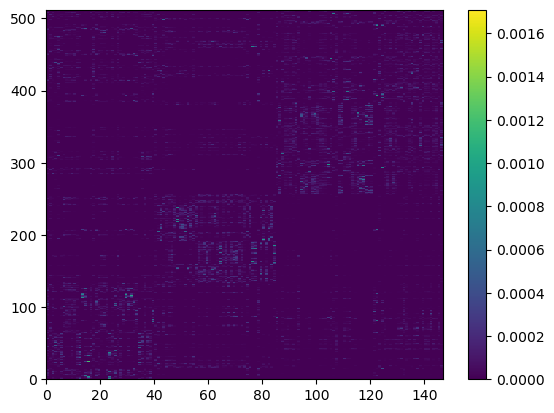

In [607]:
plt.pcolormesh(coupling)
plt.colorbar()
plt.show()

In [608]:
# build sets of true cells per spot
S = {f'spot_{j}': np.where(cells_to_spots == f'spot_{j}')[0] for j in range(n_spots)}

# per-cell distance to assigned spot (min to that spot’s true cells)
delta = np.array([
    tree_distance_matrix.values[i, S[w_assignments[i]]].min()
    for i in range(w_assignments.shape[0])
])

mean_tree_dist = delta.mean()
mean_tree_dist

np.float64(0.6371527777777778)

In [609]:
best_cell_in_spot = np.argmax(coupling, axis=1)

In [ ]:
# Make matrix of clades by spots containing the normalized average coupling weight of each clade in each spot, using the true cell-clade assignments

# Get all unique clades in the same order as appear in the data
clade_labels = ss_simulated_adata.obs['clade_level2'].astype(str)
unique_clades = np.sort(clade_labels.unique())
n_clades = len(unique_clades)

# Map each cell to its clade index
cell_clade_idx = clade_labels.map({clade: idx for idx, clade in enumerate(unique_clades)}).values

# Initialize (clades x spots) matrix
clade_spot_coupling = np.zeros((n_clades, coupling.shape[1]))

for c_idx, clade in enumerate(unique_clades):
    # mask of cells belonging to this clade
    cell_mask = clade_labels == clade
    # Subset rows of coupling matrix for cells in this clade and compute mean over cells
    clade_spot_coupling[c_idx, :] = coupling[cell_mask.values, :].mean(axis=0)

# Normalize across clades for each spot (columns sum to 1, i.e., each spot's weights across clades sum to 1)
clade_spot_coupling_norm = clade_spot_coupling / (clade_spot_coupling.sum(axis=0, keepdims=True) + 1e-12)  # add epsilon to avoid division by zero

# Optionally, put in a DataFrame for prettier display
clade_spot_coupling_df = pd.DataFrame(clade_spot_coupling_norm, index=unique_clades, columns=[f'spot_{j}' for j in range(coupling.shape[1])])

spot_clade_fractions = clade_spot_coupling_df.T.loc[spatial_simulated_adata.obs.index]
spatial_simulated_adata.obsm['inferred_clade_level2_fractions'] = spot_clade_fractions.values

/var/folders/d4/tfj5y66n2zzddb2k40xhyhk80000gp/T/ipykernel_80394/2141775905.py:10: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)


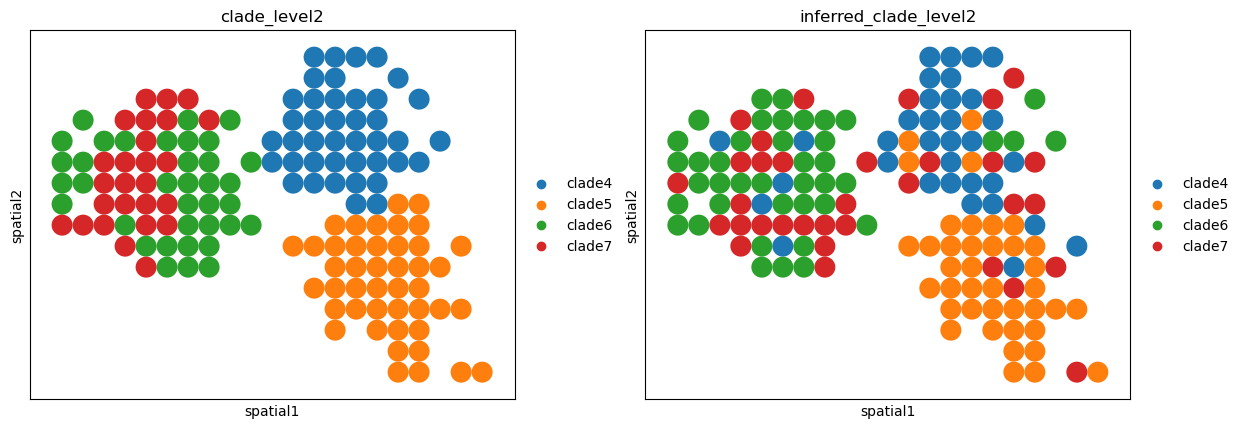

In [621]:
inferred_clades_assignments = []
for spot in range(n_spots):
    # Get fraction of cells 
    best_cell_in_spot = int(np.argmax(coupling[:, spot]))
    inferred_clades_assignments.append(ss_simulated_adata.obs.loc[ss_simulated_adata.obs.index[best_cell_in_spot], 'clade_level2'])
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments

# Color the spatial data by the clade of the inferred cells assigned to each spot
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments
sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)


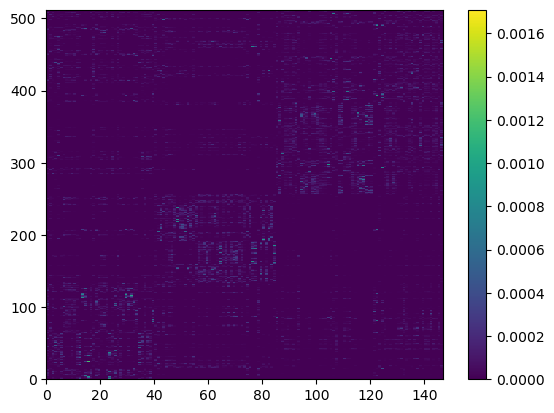

In [622]:
plt.pcolormesh(coupling)
plt.colorbar()
plt.show()

In [ ]:
# See learned trait activations per spot
spot_cell_type_proportions = jnp.einsum('ji,ik->jk', coupling.T * coupling.shape[1], cell_type_assignments)
spot_mean = jnp.einsum('jk,kg->jg', spot_cell_type_proportions, cell_type_signatures)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(axs[0])
plt.pcolormesh(spatial_simulated_adata.X)
plt.colorbar()
plt.title('Data')
plt.sca(axs[1])
plt.pcolormesh(spot_mean)
plt.colorbar()
plt.title('Prediction')
plt.tight_layout()
plt.show()

# Color the spatial data by the clade of the inferred cells assigned to each spot
for trait in range(n_traits):
    spatial_simulated_adata.obs[f'trait_{trait}'] = spot_cell_type_proportions[:, trait]
sc.pl.spatial(spatial_simulated_adata, color=[f'trait_{trait}' for trait in range(n_traits)] + [f'T{trait}' for trait in range(n_traits)], spot_size=.05)

In [569]:
from scipy.stats import pearsonr

# Compute Pearson correlation between true and estimated trait activations across spots, for each trait
per_trait_corrs = []
for trait in range(n_traits):
    # "True": spatial_simulated_adata.X = (n_spots, n_traits)
    # "Estimate": spot_mean = (n_spots, n_traits)
    r, _ = pearsonr(spatial_simulated_adata.X[:, trait], spot_mean[:, trait])
    per_trait_corrs.append(r)

mean_pearson_corr = np.mean(per_trait_corrs)
print(f"Mean Pearson correlation across traits: {mean_pearson_corr:.3f}")

Mean Pearson correlation across traits: 0.963


In [627]:
inferred_clade2.shape

(147, 4)

In [628]:
from scipy.stats import pearsonr

# Compute Pearson correlation between true and estimated clade2 subclones across spots, for each trait
per_clade2_corrs = []
true_clade2 = spatial_simulated_adata.obsm["clade_level2_fractions"]  # shape (n_spots, n_clade2)
inferred_clade2 = spatial_simulated_adata.obsm["inferred_clade_level2_fractions"].values  # shape (n_spots, n_clade2)

for clade in range(true_clade2.shape[1]):
    r, _ = pearsonr(true_clade2[:, clade], inferred_clade2[:, clade])
    per_clade2_corrs.append(r)

mean_clade2_pearson_corr = np.mean(per_clade2_corrs)
print(f"Mean Pearson correlation across clade2 subclones: {mean_clade2_pearson_corr:.3f}")

Mean Pearson correlation across clade2 subclones: -0.308


### Gromov-Wasserstein OT on tree and space only

In [455]:
file_path = os.path.join(os.getcwd(), "../src/", "spotr.py")
spec = importlib.util.spec_from_file_location("spotr", file_path)
spotr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(spotr)

In [ ]:
coupling, _ = spotr.sinkhorn_fgw(C_feature, C_tree, C_space, a, b, .01, 
T_sinkhorn=100, J_alt=20, alpha=1.0, gamma0=None, uv0=None)

gw_assignments = np.argmax(coupling, axis=1)
gw_assignments = spatial_simulated_adata.obs.index[gw_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(gw_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")

In [ ]:
coupling

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the coupling matrix as a pcolormesh
pcm0 = axs[0].pcolormesh(coupling)
fig.colorbar(pcm0, ax=axs[0])
axs[0].set_title('Coupling ($\gamma$)')

# Compute GW cost matrix at alpha=1 (C_gw)
C_gw = spotr.build_fgw_cost(
    alpha=1.0, 
    C_feature=C_feature, 
    C_tree=C_tree, 
    C_space=C_space, 
    a=a, 
    b=b, 
    gamma=coupling,
    sF_ref=sF_ref,
    sL_ref=sL_ref,
)
pcm1 = axs[1].pcolormesh(C_gw)
fig.colorbar(pcm1, ax=axs[1])
axs[1].set_title(r'$C_\mathrm{GW}$ (tree/space only)')

plt.tight_layout()
plt.show()


In [ ]:
spotr.deconvolution_loss(Y, coupling, cell_type_assignments, cell_type_signatures, .01)

In [ ]:
# per-cell distance to assigned spot (min to that spot’s true cells)
delta = np.array([
    tree_distance_matrix.values[i, S[gw_assignments[i]]].min()
    for i in range(gw_assignments.shape[0])
])

mean_tree_dist = delta.mean()
mean_tree_dist

/var/folders/d4/tfj5y66n2zzddb2k40xhyhk80000gp/T/ipykernel_80394/1242013843.py:9: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)


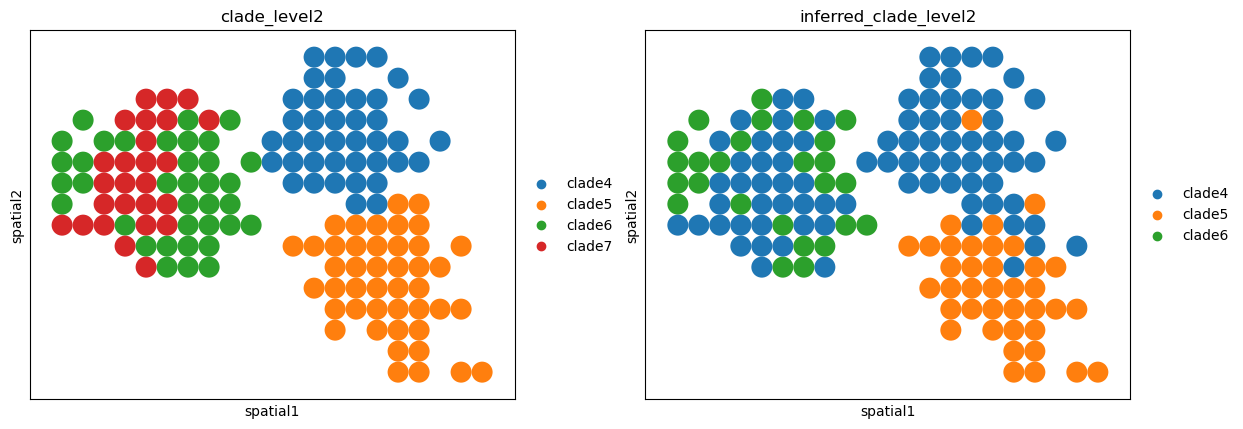

In [559]:
inferred_clades_assignments = []
for spot in range(n_spots):
    best_cell_in_spot = int(np.argmax(coupling[:, spot]))
    inferred_clades_assignments.append(ss_simulated_adata.obs.loc[ss_simulated_adata.obs.index[best_cell_in_spot], 'clade_level2'])
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments

# Color the spatial data by the clade of the inferred cells assigned to each spot
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments
sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)

In [ ]:
# See learned trait activations per spot
spot_cell_type_proportions = jnp.einsum('ji,ik->jk', coupling.T * coupling.shape[1], cell_type_assignments)
spot_mean = jnp.einsum('jk,kg->jg', spot_cell_type_proportions, cell_type_signatures)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(axs[0])
plt.pcolormesh(spatial_simulated_adata.X)
plt.colorbar()
plt.title('Data')
plt.sca(axs[1])
plt.pcolormesh(spot_mean)
plt.colorbar()
plt.title('Prediction')
plt.tight_layout()
plt.show()

# Color the spatial data by the clade of the inferred cells assigned to each spot
for trait in range(n_traits):
    spatial_simulated_adata.obs[f'trait_{trait}'] = spot_cell_type_proportions[:, trait]
sc.pl.spatial(spatial_simulated_adata, color=[f'trait_{trait}' for trait in range(n_traits)] + [f'T{trait}' for trait in range(n_traits)], spot_size=.05)

### Fused Gromov-Wasserstein OT

In [478]:
file_path = os.path.join(os.getcwd(), "../src/", "spotr.py")
spec = importlib.util.spec_from_file_location("spotr", file_path)
spotr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(spotr)

In [ ]:
spot_means = []
cgws = []
for alpha in [0., .1, .5, .8, .9, 1.]:
# alpha = .1
    coupling, uv = spotr.sinkhorn_fgw(C_feature, C_tree, C_space, a, b, .01, 
    T_sinkhorn=100, J_alt=100, alpha=alpha, gamma0=None, uv0=None)
    # sF_ref = spotr.mad_abs(spotr.dc(C_feature,a,b))                      # fixed
    # sL_ref = spotr.mad_abs(spotr.dc(spotr.compute_Lgw(C_tree,C_space,a,b,gamma0),a,b)) # at a reference gamma_ref    
    # cgw = spotr.build_fgw_cost(alpha, C_feature, C_tree, C_space, a, b, gamma0, sF_ref, sL_ref)
    cgws.append(coupling)
    # spot_cell_type_proportions = jnp.einsum('ji,ik->jk', coupling.T * coupling.shape[1], cell_type_assignments)
    # spot_mean = jnp.einsum('jk,kg->jg', spot_cell_type_proportions, cell_type_signatures)
    # spot_means.append(spot_mean)
    print(alpha, spotr.deconvolution_loss(Y, coupling, cell_type_assignments, cell_type_signatures, .01))
fgw_assignments = np.argmax(coupling, axis=1)
fgw_assignments = spatial_simulated_adata.obs.index[fgw_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(fgw_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")

In [ ]:
plt.pcolormesh(cgws[-1])
plt.colorbar()

In [ ]:
plt.pcolormesh(coupling)
plt.colorbar()

In [ ]:
# Subplots of cgw matrices
fig, axs = plt.subplots(1, len(cgws), figsize=(4 * len(cgws), 4))
if len(cgws) == 1:
    axs = [axs]
alphas = [0., .1, .5, .8, 1.]
for i, (ax, cgw, alpha) in enumerate(zip(axs, cgws, alphas)):
    im = ax.imshow(cgw, aspect='auto')
    ax.set_title(f'FGW cost (alpha={alpha})')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


In [ ]:
n_alphas = len(spot_means)
fig, axs = plt.subplots(1, n_alphas, figsize=(5 * n_alphas, 4))
if n_alphas == 1:
    axs = [axs]
for i, spot_mean in enumerate(spot_means):
    im = axs[i].pcolormesh(spot_mean, vmax=0.8, vmin=.1)
    plt.colorbar(im, ax=axs[i])
    axs[i].set_title(f'spot_means[{i}]')
plt.tight_layout()
plt.show()

In [ ]:
inferred_clades_assignments = []
for spot in range(n_spots):
    best_cell_in_spot = int(np.argmax(coupling[:, spot]))
    inferred_clades_assignments.append(ss_simulated_adata.obs.loc[ss_simulated_adata.obs.index[best_cell_in_spot], 'clade_level2'])
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments

# Color the spatial data by the clade of the inferred cells assigned to each spot
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments
sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)


In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the coupling matrix as a pcolormesh
pcm0 = axs[0].pcolormesh(coupling)
fig.colorbar(pcm0, ax=axs[0])
axs[0].set_title('Coupling ($\gamma$)')

# Compute GW cost matrix at alpha=1 (C_gw)
C_fgw = spotr.build_fgw_cost(
    alpha=alpha, 
    C_feature=C_feature, 
    C_tree=C_tree, 
    C_space=C_space, 
    a=a, 
    b=b, 
    gamma=coupling,
    sF_ref=sF_ref,
    sL_ref=sL_ref,
)
pcm1 = axs[1].pcolormesh(C_fgw)
fig.colorbar(pcm1, ax=axs[1])
axs[1].set_title(r'$C_\mathrm{FGW}$')

plt.tight_layout()
plt.show()


In [ ]:
plt.pcolormesh(coupling.T * coupling.shape[1])
plt.colorbar()
plt.show()

In [ ]:
# See learned trait activations per spot
spot_cell_type_proportions = jnp.einsum('ji,ik->jk', coupling.T * coupling.shape[1], cell_type_assignments)
spot_mean = jnp.einsum('jk,kg->jg', spot_cell_type_proportions, cell_type_signatures)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(axs[0])
plt.pcolormesh(spatial_simulated_adata.X)
plt.colorbar()
plt.title('Data')
plt.sca(axs[1])
plt.pcolormesh(spot_mean)
plt.colorbar()
plt.title('Prediction')
plt.tight_layout()
plt.show()

# Color the spatial data by the clade of the inferred cells assigned to each spot
for trait in range(n_traits):
    spatial_simulated_adata.obs[f'trait_{trait}'] = spot_cell_type_proportions[:, trait]
sc.pl.spatial(spatial_simulated_adata, color=[f'trait_{trait}' for trait in range(n_traits)] + [f'T{trait}' for trait in range(n_traits)], spot_size=.05)

In [1834]:
# import matplotlib.pyplot as plt

# # Correlation-based assignment (first)
# corr_matrix = mappers.pairwise_correlations(np.asarray(ss_transcriptomes), np.asarray(spatial_transcriptomes))
# corr_assignments = np.argmax(corr_matrix, axis=1)
# corr_assignments = spatial_simulated_adata.obs.index[corr_assignments]
# corr_accuracy = np.mean(corr_assignments == cells_to_spots)

# # OT (expression only)
# ot_coupling = mappers.wot(np.asarray(ss_transcriptomes), np.asarray(spatial_transcriptomes))
# ot_assignments = np.argmax(ot_coupling, axis=1)
# ot_assignments = spatial_simulated_adata.obs.index[ot_assignments]
# ot_accuracy = np.mean(ot_assignments == cells_to_spots)

# # GW (tree+space only)
# gw_coupling = mappers.gwot(np.asarray(tree_distance_matrix), np.asarray(spatial_distance_matrix))
# gw_assignments = np.argmax(gw_coupling, axis=1)
# gw_assignments = spatial_simulated_adata.obs.index[gw_assignments]
# gw_accuracy = np.mean(gw_assignments == cells_to_spots)

# # FGW for different alpha values
# fgw_accuracies = {}
# for alpha in [0.1, 0.5, 0.9]:
#     fgw_coupling = mappers.fgwot(
#         np.asarray(ss_transcriptomes),
#         np.asarray(spatial_transcriptomes),
#         np.asarray(tree_distance_matrix),
#         np.asarray(spatial_distance_matrix),
#         alpha=alpha,
#     )
#     fgw_assignments = np.argmax(fgw_coupling, axis=1)
#     fgw_assignments = spatial_simulated_adata.obs.index[fgw_assignments]
#     fgw_accuracy = np.mean(fgw_assignments == cells_to_spots)
#     fgw_accuracies[f"FGW (alpha={alpha})"] = fgw_accuracy

# # Collect accuracies
# accuracies = {
#     "Correlation (expression only)": corr_accuracy,
#     "OT (expression only)": ot_accuracy,
#     "GW (tree+space only)": gw_accuracy,
# }
# accuracies.update(fgw_accuracies)

# # Plot
# plt.figure(figsize=(7, 4), dpi=200)
# bar_colors = ["#8172B3", "#4C72B0", "#55A868", "#C44E52", "#E17C05", "#B07AA1"][:len(accuracies)]
# plt.bar(accuracies.keys(), accuracies.values(), color=bar_colors)
# plt.ylabel("Assignment Accuracy")
# plt.ylim(0, 1)
# plt.title("Assignment Accuracy by Method")
# plt.xticks(rotation=20)
# plt.show()


### Joint FGW and alpha learning through deconvolution (ours) 

In [495]:
file_path = os.path.join(os.getcwd(), "../src/", "spotr.py")
spec = importlib.util.spec_from_file_location("spotr", file_path)
spotr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(spotr)

In [ ]:
import jax.numpy as jnp
# K = 5
#cell_type_assignments = jnp.ones((X.shape[0], K))
# cell_type_assignments = jnp.array(trait_activations.values) / jnp.sum(trait_activations.values, axis=1, keepdims=True)
#cell_type_signatures = jnp.ones((K, Y.shape[1]))
# cell_type_signatures = jnp.array(ex_simulator.trait_signatures.values)
sigma = .01

alpha_hists = []
loss_hists = []
for beta in [-2.]:
    alpha, alpha_hist, loss_hist, coupling = spotr.learn_alpha_gamma_fgw(C_feature, Y, C_tree, C_space, a, b,
                                        cell_type_assignments, cell_type_signatures, sigma,
                                    eps=0.01, T_sinkhorn=100, J_alt=20,  K_outer=100, lr=1e-1, beta0=beta, gamma0=None, uv0=None)
    alpha_hists.append(alpha_hist)
    loss_hists.append(loss_hist)

spotr_assignments = np.argmax(coupling, axis=1)
spotr_assignments = spatial_simulated_adata.obs.index[spotr_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(spotr_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot loss trace
for i, loss_hist in enumerate(loss_hists):
    axs[0].plot(loss_hist)
axs[0].set_title("Loss Traces")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")

# Plot alpha trace
for i, alpha_hist in enumerate(alpha_hists):
    axs[1].plot(alpha_hist)
axs[1].set_title("Alpha Traces")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Alpha")
axs[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


In [ ]:
alpha_hists[0][-1]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the coupling matrix as a pcolormesh
pcm0 = axs[0].pcolormesh(coupling)
fig.colorbar(pcm0, ax=axs[0])
axs[0].set_title('Coupling ($\gamma$)')

# Compute GW cost matrix at alpha=1 (C_gw)
C_fgw = spotr.build_fgw_cost(
    alpha=alpha, 
    C_feature=C_feature, 
    C_tree=C_tree, 
    C_space=C_space, 
    a=a, 
    b=b, 
    gamma=coupling,
    sF_ref=sF_ref,
    sL_ref=sL_ref,
)
pcm1 = axs[1].pcolormesh(C_fgw)
fig.colorbar(pcm1, ax=axs[1])
axs[1].set_title(r'$C_\mathrm{FGW}$')

plt.tight_layout()
plt.show()


In [ ]:
plt.pcolormesh(coupling * n_spots)
plt.colorbar()
plt.show()

In [ ]:
inferred_clades_assignments = []
for spot in range(n_spots):
    best_cell_in_spot = int(np.argmax(coupling[:, spot]))
    inferred_clades_assignments.append(ss_simulated_adata.obs.loc[ss_simulated_adata.obs.index[best_cell_in_spot], 'clade_level2'])
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments

# Color the spatial data by the clade of the inferred cells assigned to each spot
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments
sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)


In [ ]:
# See learned trait activations per spot
spot_cell_type_proportions = jnp.einsum('ji,ik->jk', coupling.T * coupling.shape[1], cell_type_assignments)
spot_mean = jnp.einsum('jk,kg->jg', spot_cell_type_proportions, cell_type_signatures)
print(spotr.deconvolution_loss(Y, coupling, cell_type_assignments, cell_type_signatures, sigma))

# spot_cell_type_proportions = jnp.einsum('ji,ik->jk', coupling.T * coupling.shape[1] * 100., cell_type_assignments)
# spot_mean = jnp.einsum('jk,kg->jg', spot_cell_type_proportions, cell_type_signatures)
# print(tfp.distributions.Normal(spot_mean, sigma).log_prob(Y).sum())
# print(spotr.deconvolution_loss(Y, coupling * 100., cell_type_assignments, cell_type_signatures, sigma))

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(axs[0])
plt.pcolormesh(spatial_simulated_adata.X)
plt.colorbar()
plt.title('Data')
plt.sca(axs[1])
plt.pcolormesh(spot_mean)
plt.colorbar()
plt.title('Prediction')
plt.tight_layout()
plt.show()

# Color the spatial data by the clade of the inferred cells assigned to each spot
for trait in range(n_traits):
    spatial_simulated_adata.obs[f'trait_{trait}'] = spot_cell_type_proportions[:, trait]
sc.pl.spatial(spatial_simulated_adata, color=[f'trait_{trait}' for trait in range(n_traits)] + [f'T{trait}' for trait in range(n_traits)], spot_size=.05)

In [ ]:
# Plot correlation with true trait activations (column subplots)
fig, axs = plt.subplots(1, n_traits, figsize=(5 * n_traits, 4), squeeze=False)
for trait in range(n_traits):
    ax = axs[0, trait]
    for clade in spatial_simulated_adata.obs['clade_level2'].unique():
        spots_in_clade = np.where(spatial_simulated_adata.obs['clade_level2'] == clade)[0]
        ax.scatter(
            spatial_simulated_adata.obs[f'T{trait}'].values[spots_in_clade],
            spatial_simulated_adata.obs[f'trait_{trait}'].values[spots_in_clade],
            alpha=0.5,
            label=clade
        )
    ax.set_xlabel(f'True Trait {trait}')
    ax.set_ylabel(f'Learned Trait {trait}')
    ax.set_title(f'Correlation\n True vs Learned Trait {trait}')
    ax.legend(fontsize='small')
plt.tight_layout()
plt.show()


### Per-clade FGW

In [522]:
n_cells = ss_simulated_adata.shape[0]
n_clades = len(ss_simulated_adata.obs['clade_level2'].unique())

beta0 = jnp.zeros((n_clades,))

# omega: (n_cells, n_clades), one-hot encoding each cell's clade
cell_clades = ss_simulated_adata.obs['clade_level2'].values
clade_to_idx = {clade: i for i, clade in enumerate(np.unique(cell_clades))}
omega = np.zeros((n_cells, n_clades), dtype=np.float32)
for i, clade in enumerate(cell_clades):
    omega[i, clade_to_idx[clade]] = 1.0

# Omega: (n_cells, n_cells), 1 if same clade, else 0 (symmetric)
clade_sizes = np.sum(omega, axis=0)
# Omega is (n_cells, n_cells), 1 if same clade, else 0. Now rescale so within each clade, values are 1/(size of clade).
Omega = (omega @ omega.T).astype(np.float32)
row_sums = Omega.sum(axis=1, keepdims=True)
Omega = Omega / np.maximum(row_sums, 1e-8)
Omega = Omega #* n_cells
# clade_sizes = np.sum(omega, axis=0)  # (n_clades,)
# clade_indices = np.argmax(omega, axis=1)  # which clade each cell belongs to
# Omega *= n_cells / clade_sizes[clade_indices][:, None]  # each row is divided by its cell's clade size
# # Omega = Omega / clade_sizes[np.newaxis, :]

omega = jnp.array(omega)
Omega = jnp.array(Omega)
W_within = Omega.copy()
W_assign = omega.copy()

In [ ]:
plt.pcolormesh(Omega)
plt.colorbar()

In [ ]:
alpha = jnp.array([1.0]*n_clades)
coupling, _ = spotr.sinkhorn_cladefgw(C_feature, C_tree, C_space, a, b, 0.01, omega, Omega, 
                    T_sinkhorn=100, J_alt=100, alpha=alpha, gamma0=None, uv0=None)

clade_fgw_assignments = np.argmax(coupling, axis=1)
clade_fgw_assignments = spatial_simulated_adata.obs.index[clade_fgw_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(clade_fgw_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")

In [ ]:
plt.pcolormesh(coupling)
plt.colorbar()
plt.show()

In [ ]:
plt.pcolormesh(spotr.compute_Lcladegw(C_tree, C_space, a, b, gamma0, Omega))
plt.colorbar()
plt.show()

plt.pcolormesh(spotr.compute_Lcladegw(C_tree, C_space, a, b, gamma0, Omega * 0 + 1))
plt.colorbar()
plt.show()

plt.pcolormesh(spotr.compute_Lgw(C_tree, C_space, a, b, gamma0))
plt.colorbar()
plt.show()

In [ ]:
gamma0 = (a[:, None] * b[None, :])
C_clade_fgw = spotr.build_cladefgw_cost(jnp.array([1.0]*n_clades), C_feature, C_tree, C_space, a, b, gamma0, omega, Omega)
plt.pcolormesh(C_clade_fgw)
plt.colorbar()
plt.show()

In [ ]:
gamma0 = (a[:, None] * b[None, :])
C_clade_fgw = spotr.build_fgw_cost(1., C_feature, C_tree, C_space, a, b, gamma0, sF_ref, sL_ref)
plt.pcolormesh(C_clade_fgw)
plt.colorbar()
plt.show()

In [ ]:
inferred_clades_assignments = []
for spot in range(n_spots):
    best_cell_in_spot = int(np.argmax(coupling[:, spot]))
    inferred_clades_assignments.append(ss_simulated_adata.obs.loc[ss_simulated_adata.obs.index[best_cell_in_spot], 'clade_level2'])
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments

# Color the spatial data by the clade of the inferred cells assigned to each spot
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments
sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)


In [ ]:
# See learned trait activations per spot
spot_cell_type_proportions = jnp.einsum('ji,ik->jk', coupling.T * coupling.shape[1], cell_type_assignments)
spot_mean = jnp.einsum('jk,kg->jg', spot_cell_type_proportions, cell_type_signatures)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(axs[0])
plt.pcolormesh(spatial_simulated_adata.X)
plt.colorbar()
plt.title('Data')
plt.sca(axs[1])
plt.pcolormesh(spot_mean)
plt.colorbar()
plt.title('Prediction')
plt.tight_layout()
plt.show()

# Color the spatial data by the clade of the inferred cells assigned to each spot
for trait in range(n_traits):
    spatial_simulated_adata.obs[f'trait_{trait}'] = spot_cell_type_proportions[:, trait]
sc.pl.spatial(spatial_simulated_adata, color=[f'trait_{trait}' for trait in range(n_traits)] + [f'T{trait}' for trait in range(n_traits)], spot_size=.05)

### Joint FGW and per-clade alpha learning through deconvolution (ours)

In [1558]:
file_path = os.path.join(os.getcwd(), "../src/", "spotr.py")
spec = importlib.util.spec_from_file_location("spotr", file_path)
spotr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(spotr)

In [ ]:
import jax.numpy as jnp
# K = 5
#cell_type_assignments = jnp.ones((X.shape[0], K))
# cell_type_assignments = jnp.array(trait_activations.values) / jnp.sum(trait_activations.values, axis=1, keepdims=True)
#cell_type_signatures = jnp.ones((K, Y.shape[1]))
# cell_type_signatures = jnp.array(ex_simulator.trait_signatures.values)
sigma = .01

alpha_hists = []
loss_hists = []
couplings = []
for beta in [-1., 0.0, 1.]:#[-2.0, -1.0, 0.0, 1.0, 2.0]:
    alphas, alphas_hist, loss_hist, coupling = spotr.learn_alpha_gamma_cladefgw(C_feature, Y, C_tree, C_space, a, b,
                                        cell_type_assignments, cell_type_signatures, sigma,
                                        omega, Omega,
                                        eps=0.01, T_sinkhorn=100, J_alt=20, 
                                        K_outer=100, lr=1e-1, beta0=jnp.array([beta]*n_clades), gamma0=None, uv0=None)
    alpha_hists.append(alphas_hist)
    loss_hists.append(loss_hist)
    couplings.append(coupling.copy())

spotr_assignments = np.argmax(coupling, axis=1)
spotr_assignments = spatial_simulated_adata.obs.index[spotr_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(spotr_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")

In [ ]:
alpha_hists[0][0,-1], alpha_hists[0][1,-1]

In [ ]:
n_betas = len(alpha_hists)
n_clades = alpha_hists[0].shape[0]

# Set up a single column for losses, then N rows for alpha traces to the right
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(n_betas, 2, width_ratios=[1, 2])

# --- Get colors for each beta ---
# Use matplotlib default color cycle
from itertools import cycle
default_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(default_cycler)
beta_colors = [next(color_cycle) for _ in range(n_betas)]

# Loss panel (shared for all betas)
ax_loss = fig.add_subplot(gs[:, 0])
for i, loss_hist in enumerate(loss_hists):
    ax_loss.plot(loss_hist, label=f'Beta {i}', color=beta_colors[i])
ax_loss.set_title("Loss Traces")
ax_loss.set_xlabel("Iteration")
ax_loss.set_ylabel("Loss")
# ax_loss.legend(title='Beta idx', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

# Alpha panels, one for each beta
for i, alphas_hist in enumerate(alpha_hists):
    ax_alpha = fig.add_subplot(gs[i, 1])
    for j in range(n_clades):
        ax_alpha.plot(alphas_hist[j, :], label=f"Clade {j}", color=beta_colors[i])
    plt.ylim(0, 1)
    # ax_alpha.set_title(f"Alpha Trace (beta={i})")
    # ax_alpha.set_xlabel("Iteration")
    ax_alpha.set_ylabel("Alpha")
    # ax_alpha.legend(fontsize='small', loc='best')

plt.tight_layout()
plt.show()

In [ ]:
alpha_hists[0][0,-1], alpha_hists[0][1,-1]

In [550]:
coupling = couplings[0].copy()

In [ ]:
betas = jnp.array([beta]*n_clades)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot loss trace
for i, loss_hist in enumerate(loss_hists):
    axs[0].plot(loss_hist)
axs[0].set_title("Loss Traces")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")

# Plot alpha trace
for i, alphas_hist in enumerate(alpha_hists):
    for j in range(n_clades):
        axs[1].plot(alphas_hist[j,:], label=f'beta={betas[j]}')
axs[1].set_title("Alpha Trace")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Alpha")

plt.tight_layout()
plt.show()


In [ ]:
plt.pcolormesh(coupling)
plt.colorbar()
plt.show()

In [ ]:
gamma0 = (a[:, None] * b[None, :])
C_clade_fgw = spotr.build_cladefgw_cost(jnp.array(alphas), C_feature, C_tree, C_space, a, b, coupling, omega, Omega)
plt.pcolormesh(C_clade_fgw)
plt.colorbar()
plt.show()

In [ ]:
plt.pcolormesh(couplings[0])
plt.colorbar()
plt.show()

In [ ]:
inferred_clades_assignments = []
for spot in range(n_spots):
    best_cell_in_spot = int(np.argmax(coupling[:, spot]))
    inferred_clades_assignments.append(ss_simulated_adata.obs.loc[ss_simulated_adata.obs.index[best_cell_in_spot], 'clade_level2'])
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments

# Color the spatial data by the clade of the inferred cells assigned to each spot
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments
sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)


In [ ]:
# See learned trait activations per spot
spot_cell_type_proportions = jnp.einsum('ji,ik->jk', coupling.T * coupling.shape[1], cell_type_assignments)
spot_mean = jnp.einsum('jk,kg->jg', spot_cell_type_proportions, cell_type_signatures)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
plt.sca(axs[0])
plt.pcolormesh(spatial_simulated_adata.X)
plt.colorbar()
plt.title('Data')
plt.sca(axs[1])
plt.pcolormesh(spot_mean)
plt.colorbar()
plt.title('Prediction')
plt.tight_layout()
plt.show()

# Color the spatial data by the clade of the inferred cells assigned to each spot
for trait in range(n_traits):
    spatial_simulated_adata.obs[f'trait_{trait}'] = spot_cell_type_proportions[:, trait]
sc.pl.spatial(spatial_simulated_adata, color=[f'trait_{trait}' for trait in range(n_traits)] + [f'T{trait}' for trait in range(n_traits)], spot_size=.05)

### Per/cross clade GW

In [956]:
file_path = os.path.join(os.getcwd(), "../src/", "spotr.py")
spec = importlib.util.spec_from_file_location("spotr", file_path)
spotr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(spotr)

In [ ]:
alpha = jnp.array([1.]*n_clades)
rho = 0.
coupling, _ = spotr.sinkhorn_cladefxgw(C_feature, C_tree, C_space, a, b, 0.0001, W_assign, W_within, T_sinkhorn=100, J_alt=100, alpha=alpha, rho=rho, gamma0=None, uv0=None)

clade_fxgw_assignments = np.argmax(coupling, axis=1)
clade_fxgw_assignments = spatial_simulated_adata.obs.index[clade_fxgw_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(clade_fxgw_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot the coupling matrix as a pcolormesh
pcm0 = axs[0].pcolormesh(coupling)
fig.colorbar(pcm0, ax=axs[0])
axs[0].set_title('Coupling ($\gamma$)')

# Compute GW cost matrix at alpha=1 (C_gw)
C_xgw = spotr.build_cladefgw_cost_rho(
    alpha=alpha, 
    rho=rho,
    C_feature=C_feature, 
    C_tree=C_tree, 
    C_space=C_space, 
    a=a, 
    b=b, 
    gamma=coupling,
    W_assign=W_assign, 
    W_within=W_within,
)
pcm1 = axs[1].pcolormesh(C_xgw)
fig.colorbar(pcm1, ax=axs[1])
axs[1].set_title(r'$C_\mathrm{XGW}$ (tree/space only)')

plt.tight_layout()
plt.show()


### Joint FXGW alpha learning through deconvolution (ours)

In [458]:
file_path = os.path.join(os.getcwd(), "../src/", "spotr.py")
spec = importlib.util.spec_from_file_location("spotr", file_path)
spotr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(spotr)

In [ ]:
import jax.numpy as jnp
K = 5
#cell_type_assignments = jnp.ones((X.shape[0], K))
cell_type_assignments = jnp.array(jnp.exp(trait_activations.values)) / jnp.sum(jnp.exp(trait_activations.values), axis=1, keepdims=True)
#cell_type_signatures = jnp.ones((K, Y.shape[1]))
cell_type_signatures = jnp.array(ex_simulator.trait_signatures.values)
sigma = .01

betas_alpha0 = jnp.zeros(n_clades)
beta_rho0 = 0.0

est, alphas_hist, rho_hist, loss_hist, coupling = spotr.learn_cladefgw_with_rho(C_feature, Y, C_tree, C_space, a, b,
                                    cell_type_assignments, cell_type_signatures, sigma,
                                    W_assign, W_within,
                                    eps=0.01, T_sinkhorn=10, J_alt=20,  K_outer=100, lr=1e-2, betas_alpha0=betas_alpha0, beta_rho0=beta_rho0, gamma0=None, uv0=None)
spotr_assignments = np.argmax(coupling, axis=1)
spotr_assignments = spatial_simulated_adata.obs.index[spotr_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(spotr_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

# Plot loss trace
axs[0].plot(loss_hist)
axs[0].set_title("Loss Trace")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")

# Plot alpha trace
for i in range(n_clades):
    axs[1].plot(alphas_hist[i,:])
axs[1].set_title("Alpha Trace")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Alpha")

# Plot loss trace
axs[2].plot(rho_hist)
axs[2].set_title("Rho Trace")
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("Rho")

plt.tight_layout()
plt.show()


### Joint FGW alpha and w learning through deconvolution (ours)

In [960]:
file_path = os.path.join(os.getcwd(), "../src/", "spotr.py")
spec = importlib.util.spec_from_file_location("spotr", file_path)
spotr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(spotr)

In [ ]:
import jax.numpy as jnp
K = 5
#cell_type_assignments = jnp.ones((X.shape[0], K))
# cell_type_assignments = jnp.array(jnp.exp(trait_activations.values)) / jnp.sum(jnp.exp(trait_activations.values), axis=1, keepdims=True)
#cell_type_signatures = jnp.ones((K, Y.shape[1]))
cell_type_signatures = jnp.array(ex_simulator.trait_signatures.values)
sigma = .01

R_levels, M_levels = spotr.make_R_levels_from_Wwithin(W_within, include_root=True, include_leaves=False)

betas_alpha0 = jnp.zeros(n_clades)
n_levels = len(R_levels)
betas_w0 = jnp.zeros(n_levels)

est, alphas_hist, w_hist, eps_hist, loss_hist, coupling = spotr.learn_cladefgw_levels(C_feature, Y, C_tree, C_space, a, b,
                                    cell_type_assignments, cell_type_signatures, sigma,
                                    W_assign, R_levels,
                                    eps0=0.01, T_sinkhorn=10, J_alt=20,  K_outer=1000, lr=1e-2, schedule='', 
                                    betas_alpha0=betas_alpha0, betas_w0=betas_w0, gamma0=None, uv0=None)
spotr_assignments = np.argmax(coupling, axis=1)
spotr_assignments = spatial_simulated_adata.obs.index[spotr_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(spotr_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")

In [ ]:
est

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(10, 4))

# Plot loss trace
axs[0].plot(loss_hist)
axs[0].set_title("Loss Trace")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")

# Plot alpha trace
for i in range(n_clades):
    axs[1].plot(alphas_hist[i,:])
axs[1].set_title("Alpha Trace")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Alpha")

# Plot w trace
for i in range(n_clades):
    axs[2].plot(w_hist[i,:])
axs[2].set_title("w Trace")
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("w")

# Plot eps trace
axs[3].plot(eps_hist)
axs[3].set_title("eps Trace")
axs[3].set_xlabel("Iteration")
axs[3].set_ylabel("eps")

plt.tight_layout()
plt.show()


### Joint FXGW alpha learning through deconvolution with epsilon annealing (ours)

In [543]:
file_path = os.path.join(os.getcwd(), "../src/", "spotr.py")
spec = importlib.util.spec_from_file_location("spotr", file_path)
spotr = importlib.util.module_from_spec(spec)
spec.loader.exec_module(spotr)

In [ ]:
import jax.numpy as jnp
K = 5
#cell_type_assignments = jnp.ones((X.shape[0], K))
cell_type_assignments = jnp.array(jnp.exp(trait_activations.values)) / jnp.sum(jnp.exp(trait_activations.values), axis=1, keepdims=True)
#cell_type_signatures = jnp.ones((K, Y.shape[1]))
cell_type_signatures = jnp.array(ex_simulator.trait_signatures.values)
sigma = .01

betas_alpha0 = jnp.zeros(n_clades)
beta_rho0 = 0.0

est, alphas_hist, rho_hist, eps_hist, loss_hist, coupling = spotr.learn_cladefgw_with_rho_annealed(C_feature, Y, C_tree, C_space, a, b,
                                    cell_type_assignments, cell_type_signatures, sigma,
                                    W_assign, W_within,
                                    T_sinkhorn=100, J_alt=100,  K_outer=100, lr=1e-2, 
                                    eps0=0.01, eps_min=0.01,
                                    betas_alpha0=betas_alpha0, beta_rho0=beta_rho0, gamma0=None, uv0=None)
spotr_assignments = np.argmax(coupling, axis=1)
spotr_assignments = spatial_simulated_adata.obs.index[spotr_assignments]

# Compute accuracy: fraction of correctly assigned cells
assignment_accuracy = np.mean(spotr_assignments == cells_to_spots)
print(f"Assignment accuracy: {assignment_accuracy:.3f}")

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(10, 4))

# Plot loss trace
axs[0].plot(loss_hist)
axs[0].set_title("Loss Trace")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss")

# Plot alpha trace
for i in range(n_clades):
    axs[1].plot(alphas_hist[i,:])
axs[1].set_title("Alpha Trace")
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Alpha")

# Plot rho trace
axs[2].plot(rho_hist)
axs[2].set_title("rho Trace")
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("rho")

# Plot epsilon trace
axs[3].plot(eps_hist)
axs[3].set_title("eps Trace")
axs[3].set_xlabel("Iteration")
axs[3].set_ylabel("eps")


plt.tight_layout()
plt.show()


In [ ]:
inferred_clades_assignments = []
for spot in range(n_spots):
    best_cell_in_spot = int(np.argmax(coupling[:, spot]))
    inferred_clades_assignments.append(ss_simulated_adata.obs.loc[ss_simulated_adata.obs.index[best_cell_in_spot], 'clade_level0'])
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments

# Color the spatial data by the clade of the inferred cells assigned to each spot
spatial_simulated_adata.obs['inferred_clade_level2'] = inferred_clades_assignments
sc.pl.spatial(spatial_simulated_adata, color=['clade_level2', 'inferred_clade_level2'], spot_size=.05)


In [ ]:
plt.pcolormesh(coupling)
plt.colorbar()
plt.show()